# Explainability Part 2 (Animal)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-batch-1bin/data_batch_1.bin


In [2]:
# load the pacakges
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score


## Q7. Load data and visulizations of animal images.

torch.Size([45000, 3, 64, 64])
torch.Size([45000])
torch.Size([5000, 3, 64, 64])
torch.Size([5000])


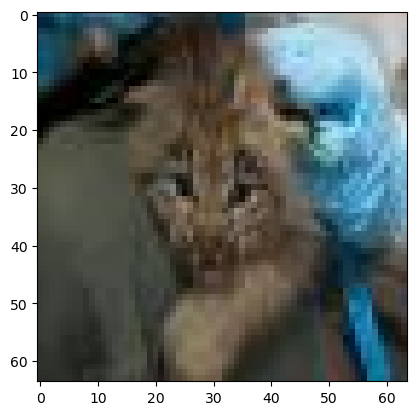

In [3]:
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


def load_data(file_path, id_bytes, label_bytes, num_images, height, width, depth):
    """
    Function to load image data from a binary file.

    Parameters:
    file_path (str): Path to the binary file.
    id_bytes (int): Number of bytes used for the image ID.
    label_bytes (int): Number of bytes used for the image label.
    num_images (int): Number of images in the binary file.
    height (int): Height of the images.
    width (int): Width of the images.
    depth (int): Depth of the images (number of color channels).

    Returns:
    images (torch.Tensor): Tensor of image data.
    labels (torch.Tensor): Tensor of image labels.
    """

    # Define the record size in bytes
    record_size = id_bytes + label_bytes + height * width * depth

    # Initialize tensors to store the image IDs, labels, and data
    ids = torch.empty((num_images, id_bytes), dtype=torch.uint8)
    labels = torch.empty((num_images, label_bytes), dtype=torch.uint8)
    images = torch.empty((num_images, depth, height, width), dtype=torch.uint8)

    # Open the binary file and read the contents
    with open(file_path, 'rb') as file:
        for i in range(num_images):
            byte_record = file.read(record_size)

            # Convert the byte string to a tensor
            byte_tensor = torch.tensor(list(byte_record), dtype=torch.uint8)

            # Extract the image ID
            ids[i] = byte_tensor[:id_bytes].view(1, -1)

            # Extract the image label
            labels[i] = byte_tensor[id_bytes:id_bytes + label_bytes].view(1, -1)

            # Extract the image data
            array_image = byte_tensor[id_bytes + label_bytes:record_size].view(depth, height, width)
            images[i] = array_image

    # Ensure labels is a 1-D tensor
    labels = labels[:, -1]

    return images, labels


if __name__ == '__main__':
    # Specify parameters (information can be found in the readme file)
    id_bytes = 4
    label_bytes = 4
    num_train_files = 1
    num_train_images = 50000
    width = 64
    height = 64
    depth = 3
    num_classes = 10

    # Load training and test data
    train_images, train_labels = load_data('/kaggle/input/data-batch-1bin/data_batch_1.bin', id_bytes, label_bytes, num_train_images, height, width, depth)

    # Split training data into training and validation sets
    train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.1, random_state=42)

    # Print shapes of datasets
    print(train_images.shape)
    print(train_labels.shape)
    print(val_images.shape)
    print(val_labels.shape)

    # Show the second training image
    plt.imshow(train_images[817].permute(1, 2, 0))
    plt.show()

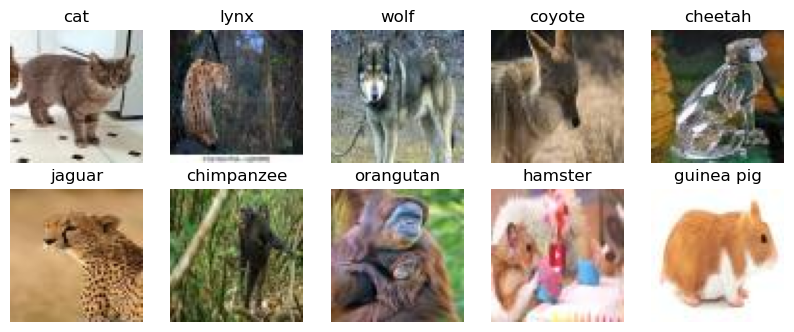

In [4]:
# Define class labels
class_labels = ['cat', 'lynx', 'wolf', 'coyote', 'cheetah', 'jaguar', 'chimpanzee', 'orangutan', 'hamster', 'guinea pig']

# Create a figure to display the images
plt.figure(figsize=(10,10))

# Iterate through each class
for i in range(num_classes):
    # Find the first image of this class
    class_idx = (train_labels == i).nonzero(as_tuple=True)[0][226]
    
    # Display the image
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_images[class_idx].permute(1, 2, 0))
    plt.title(class_labels[i])
    plt.axis('off')

plt.show()

## Q9. Vanilla deep convolutional network

In [5]:
import os
import time
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import Normalize

import numpy as np
from sklearn.model_selection import train_test_split

import torch.nn.functional as F


# Define a normalization function
def normalize(data):
    data = data.to(dtype=torch.float32)
    img_mean = data.mean(dim=(0, 2, 3))
    img_std = data.std(dim=(0, 2, 3))
    normalize = Normalize(img_mean, img_std)
    preprocessed_data = normalize(data)
    return preprocessed_data


# Define the architecture of your Linear Model. You will need to fill in the blanks!
# input_size: This is the number of input features for the linear model. If you are dealing with flattened images, this will be the total number of pixels in each image.
# output_size: This is the number of output features for the linear model. In a classification task, this is typically equal to the number of classes.

class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=64*64*3, out_features=10)

    def forward(self, x):
        x = x.reshape(x.size(0), -1)  # Flatten the input
        return self.linear(x)

# Define the architecture of your CNN. You will need to fill in the blanks!
# Think about what the input and output of each layer should be
class VanillaCNN(nn.Module):
    def __init__(self):
        super(VanillaCNN, self).__init__()

        # Define the layers of your CNN here. You will need to choose appropriate values for the parameters.
        # For example, you might have a convolutional layer like this:
        # self.conv = nn.Conv2d(in_channels='FILL_IN_THIS_VALUE', out_channels='FILL_IN_THIS_VALUE', kernel_size='FILL_IN_THIS_VALUE', padding='FILL_IN_THIS_VALUE')
        
        # Define a simple CNN with two convolutional layers and a fully connected layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2)

        # And a fully connected layer like this:
        # self.fc = nn.Linear(in_features='FILL_IN_THIS_VALUE', out_features='FILL_IN_THIS_VALUE')
        
        # Fully connected layer takes 32*16*16 nodes, outputs 10 classes
        self.fc = nn.Linear(32 * 16 * 16, 10)

        # Continue to define your network here...

    def forward(self, x):
        # Define the forward pass of your network here.
        # Remember to connect the layers as you have defined them.
        # Make sure the output of one layer matches the input of the next.
        
        # Apply first convolution, followed by ReLU nonlinearity; shape of x becomes (16, 64, 64)
        x = self.pool(F.relu(self.conv1(x)))
        # Second convolution, x shape becomes (32, 32, 32)
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten x, and feed it into the fully connected layer
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
        pass


# Define the training function
def training_loop(model, dataset_train, dataset_val, epochs, batch_size, lr, weight_decay, save_path, model_name_str, device="cpu"):
    """
    Train a neural network model for digit recognition on the MNIST dataset.

    Parameters
    ----------
    model (nn.Module): PyTorch model to be trained

    dataset_train (Dataset): PyTorch datasets for training

    dataset_val (Dataset): PyTorch datasets for validation

    epochs (int):     number of iterations through the whole dataset for training

    batch_size (int): size of a single batch of inputs

    save_path (str):  path/filename for model checkpoint, e.g. 'my_model.pt'

    model_name_str (str):  name of the model, e.g. 'VanillaCNN'

    device (str):     device on which tensors are placed; should be 'cpu' or 'cuda'.

    Returns
    -------
    model (nn.Module): final trained model

    best_moded_save_path (str):   path/filename for model checkpoint with the best validation accuracy

    device (str):      the device on which we carried out training, so we can match it
                       when we test the final model on unseen data later

    train_acc_lst, val_acc_lst, train_loss_lst, val_loss_lst (list): lists of training and validation accuracy and loss
    """

    # initialize model and move it to the device
    model.to(device)

    # initialize an optimizer to update our model's parameters during training
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # initialize a DataLoader object for each dataset
    train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

    # a PyTorch categorical cross-entropy loss object
    loss_fn = nn.CrossEntropyLoss()

    # keep track of training and validation accuracy and loss
    train_acc_lst = []
    val_acc_lst = []
    train_loss_lst = []
    val_loss_lst = []

    # time training process
    start_time = time.time()

    print("Training model: ", model_name_str)

    # run our training loop
    for epoch_idx in tqdm(range(epochs)):

        print(f"-------------------- Begin Epoch {epoch_idx} --------------------")
        epoch_start_time = time.time()

        # keep track of the best validation accuracy; if improved upon, save checkpoint
        best_acc = 0.0

        # loop through the entire dataset once per epoch
        train_loss = 0.0
        train_acc = 0.0
        train_total = 0

        epoch_val_acc_lst = []
        epoch_val_loss_lst = []

        for batch_idx, batch in enumerate(tqdm(train_dataloader)):

            model.train()

            # clear gradients
            optimizer.zero_grad()

            # unpack data and labels
            x, y = batch
            x = x.to(device)
            y = y.to(device)

            # generate predictions and compute loss
            output = model(x.float())  # (batch_size, 10)
            loss = loss_fn(output, y)

            # compute accuracy
            preds = output.argmax(dim=1)
            acc = preds.eq(y).sum().item() / len(y)

            # compute gradients and update model parameters
            loss.backward()
            optimizer.step()

            # update batch training statistics
            train_loss += (loss * len(x))
            train_acc += (acc * len(x))
            train_total += len(x)

            ##########################
            # perform validation every 20 batch
            if batch_idx > 0 and batch_idx % 20 == 0:
                batch_val_loss = 0.0
                batch_val_acc = 0.0
                batch_val_total = 0

                model.eval()
                for val_batch_idx, batch in enumerate(val_dataloader):
                    # don't compute gradients during validation
                    with torch.no_grad():
                        # unpack data and labels
                        x, y = batch
                        x = x.to(device)
                        y = y.to(device)

                        # generate predictions and compute loss
                        output = model(x.float())
                        loss = loss_fn(output, y)

                        # compute accuracy
                        preds = output.argmax(dim=1)
                        acc = preds.eq(y).sum().item() / len(y)

                        # update batch validation statistics
                        batch_val_loss += (loss * len(x))
                        batch_val_acc += (acc * len(x))
                        batch_val_total += len(x)

                batch_val_loss /= batch_val_total
                batch_val_acc /= batch_val_total
                epoch_val_acc_lst.append(batch_val_acc)
                epoch_val_loss_lst.append(batch_val_loss.detach().cpu().numpy().item())

                if batch_val_acc > best_acc:
                    best_acc = batch_val_acc
                    best_model_save_path = save_path + "E" + str(epoch_idx) + "B" + str(
                        batch_idx) + "_" + model_name_str + ".pt"
                    print(
                        f"Epoch {epoch_idx}, Batch {batch_idx}: New best val acc {batch_val_acc :0.3f}, model weights saved to {best_model_save_path}")
                    torch.save(model.state_dict(), best_model_save_path)

        # update epoch training statistics
        train_loss /= train_total
        train_acc /= train_total
        train_acc_lst.append(train_acc)
        train_loss_lst.append(train_loss.detach().cpu().numpy().item())

        # update epoch validation statistics
        val_acc = np.mean(epoch_val_acc_lst)
        val_loss = np.mean(epoch_val_loss_lst)
        val_acc_lst.append(val_acc)
        val_loss_lst.append(val_loss)

        print(
            f"End of Epoch {epoch_idx}: train loss {train_loss :0.3f}, val loss {val_loss :0.3f}; train acc {train_acc :0.3f}, val acc {val_acc :0.3f}")
        print(
            f"Current total training time: {time.time() - start_time :0.3f} seconds; time for this epoch: {time.time() - epoch_start_time :0.3f} seconds")
        print(f"-------------------------------------------------------")

    return model, best_model_save_path, device, train_acc_lst, val_acc_lst, train_loss_lst, val_loss_lst


if __name__ == '__main__':

    # Define the saving path for trained models
    save_path = "./VanillaCNN/"
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # Check device availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Specify parameters (information can be found in the readme file)
    id_bytes = 4
    label_bytes = 4
    num_train_files = 1
    num_train_images = 50000
    width = 64
    height = 64
    depth = 3
    num_classes = 10

    # Load training and test data
    train_images, train_labels = load_data('/kaggle/input/data-batch-1bin/data_batch_1.bin', id_bytes, label_bytes, num_train_images,
                                           height, width, depth)

    # Split training data into training and validation sets
    train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.1, random_state=42)

    norm_train_images = normalize(train_images)
    norm_val_images = normalize(val_images)

    # initialize a Dataset object for each dataset
    dataset_train = TensorDataset(norm_train_images, train_labels)
    dataset_val = TensorDataset(norm_val_images, val_labels)

    # initialize a model
    model = VanillaCNN()
    epochs = 30
    batch_size = 128
    learning_rate = 0.001
    weight_decay = 0.0001

    # train the model
    model, best_model_save_path, device, train_acc_van, val_acc_van, train_loss_van, val_loss_van = training_loop(
        model=model,
        dataset_train=dataset_train,
        dataset_val=dataset_val,
        epochs=epochs,
        batch_size=batch_size,
        lr=learning_rate,
        weight_decay=weight_decay,
        save_path="./VanillaCNN/",
        model_name_str='VanillaCNN',  # you should change this to the specific model name you are training
        device=device)
    

Training model:  VanillaCNN


  0%|          | 0/30 [00:00<?, ?it/s]

-------------------- Begin Epoch 0 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 0, Batch 20: New best val acc 0.237, model weights saved to ./VanillaCNN/E0B20_VanillaCNN.pt
Epoch 0, Batch 40: New best val acc 0.282, model weights saved to ./VanillaCNN/E0B40_VanillaCNN.pt
Epoch 0, Batch 60: New best val acc 0.338, model weights saved to ./VanillaCNN/E0B60_VanillaCNN.pt
Epoch 0, Batch 80: New best val acc 0.367, model weights saved to ./VanillaCNN/E0B80_VanillaCNN.pt
Epoch 0, Batch 100: New best val acc 0.385, model weights saved to ./VanillaCNN/E0B100_VanillaCNN.pt
Epoch 0, Batch 120: New best val acc 0.390, model weights saved to ./VanillaCNN/E0B120_VanillaCNN.pt
Epoch 0, Batch 140: New best val acc 0.410, model weights saved to ./VanillaCNN/E0B140_VanillaCNN.pt
Epoch 0, Batch 180: New best val acc 0.420, model weights saved to ./VanillaCNN/E0B180_VanillaCNN.pt
Epoch 0, Batch 220: New best val acc 0.434, model weights saved to ./VanillaCNN/E0B220_VanillaCNN.pt
Epoch 0, Batch 240: New best val acc 0.453, model weights saved to ./VanillaCNN/E0B240_VanillaCNN.p

  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 1, Batch 20: New best val acc 0.471, model weights saved to ./VanillaCNN/E1B20_VanillaCNN.pt
Epoch 1, Batch 120: New best val acc 0.471, model weights saved to ./VanillaCNN/E1B120_VanillaCNN.pt
Epoch 1, Batch 140: New best val acc 0.473, model weights saved to ./VanillaCNN/E1B140_VanillaCNN.pt
Epoch 1, Batch 180: New best val acc 0.481, model weights saved to ./VanillaCNN/E1B180_VanillaCNN.pt
Epoch 1, Batch 260: New best val acc 0.491, model weights saved to ./VanillaCNN/E1B260_VanillaCNN.pt
Epoch 1, Batch 340: New best val acc 0.492, model weights saved to ./VanillaCNN/E1B340_VanillaCNN.pt
End of Epoch 1: train loss 1.463, val loss 1.497; train acc 0.490, val acc 0.474
Current total training time: 24.133 seconds; time for this epoch: 8.470 seconds
-------------------------------------------------------
-------------------- Begin Epoch 2 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 2, Batch 20: New best val acc 0.474, model weights saved to ./VanillaCNN/E2B20_VanillaCNN.pt
Epoch 2, Batch 40: New best val acc 0.498, model weights saved to ./VanillaCNN/E2B40_VanillaCNN.pt
Epoch 2, Batch 220: New best val acc 0.511, model weights saved to ./VanillaCNN/E2B220_VanillaCNN.pt
Epoch 2, Batch 280: New best val acc 0.515, model weights saved to ./VanillaCNN/E2B280_VanillaCNN.pt
End of Epoch 2: train loss 1.347, val loss 1.430; train acc 0.532, val acc 0.496
Current total training time: 32.679 seconds; time for this epoch: 8.545 seconds
-------------------------------------------------------
-------------------- Begin Epoch 3 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 3, Batch 20: New best val acc 0.502, model weights saved to ./VanillaCNN/E3B20_VanillaCNN.pt
Epoch 3, Batch 40: New best val acc 0.512, model weights saved to ./VanillaCNN/E3B40_VanillaCNN.pt
Epoch 3, Batch 160: New best val acc 0.513, model weights saved to ./VanillaCNN/E3B160_VanillaCNN.pt
Epoch 3, Batch 180: New best val acc 0.517, model weights saved to ./VanillaCNN/E3B180_VanillaCNN.pt
Epoch 3, Batch 200: New best val acc 0.521, model weights saved to ./VanillaCNN/E3B200_VanillaCNN.pt
Epoch 3, Batch 300: New best val acc 0.525, model weights saved to ./VanillaCNN/E3B300_VanillaCNN.pt
End of Epoch 3: train loss 1.267, val loss 1.402; train acc 0.557, val acc 0.511
Current total training time: 41.087 seconds; time for this epoch: 8.407 seconds
-------------------------------------------------------
-------------------- Begin Epoch 4 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 4, Batch 20: New best val acc 0.508, model weights saved to ./VanillaCNN/E4B20_VanillaCNN.pt
Epoch 4, Batch 40: New best val acc 0.521, model weights saved to ./VanillaCNN/E4B40_VanillaCNN.pt
Epoch 4, Batch 240: New best val acc 0.529, model weights saved to ./VanillaCNN/E4B240_VanillaCNN.pt
End of Epoch 4: train loss 1.196, val loss 1.389; train acc 0.584, val acc 0.517
Current total training time: 49.512 seconds; time for this epoch: 8.424 seconds
-------------------------------------------------------
-------------------- Begin Epoch 5 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 5, Batch 20: New best val acc 0.521, model weights saved to ./VanillaCNN/E5B20_VanillaCNN.pt
Epoch 5, Batch 40: New best val acc 0.528, model weights saved to ./VanillaCNN/E5B40_VanillaCNN.pt
Epoch 5, Batch 240: New best val acc 0.528, model weights saved to ./VanillaCNN/E5B240_VanillaCNN.pt
End of Epoch 5: train loss 1.139, val loss 1.400; train acc 0.607, val acc 0.516
Current total training time: 57.963 seconds; time for this epoch: 8.450 seconds
-------------------------------------------------------
-------------------- Begin Epoch 6 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 6, Batch 20: New best val acc 0.529, model weights saved to ./VanillaCNN/E6B20_VanillaCNN.pt
Epoch 6, Batch 240: New best val acc 0.530, model weights saved to ./VanillaCNN/E6B240_VanillaCNN.pt
End of Epoch 6: train loss 1.088, val loss 1.409; train acc 0.624, val acc 0.519
Current total training time: 66.717 seconds; time for this epoch: 8.752 seconds
-------------------------------------------------------
-------------------- Begin Epoch 7 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 7, Batch 20: New best val acc 0.526, model weights saved to ./VanillaCNN/E7B20_VanillaCNN.pt
End of Epoch 7: train loss 1.038, val loss 1.434; train acc 0.640, val acc 0.516
Current total training time: 75.268 seconds; time for this epoch: 8.550 seconds
-------------------------------------------------------
-------------------- Begin Epoch 8 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 8, Batch 20: New best val acc 0.513, model weights saved to ./VanillaCNN/E8B20_VanillaCNN.pt
Epoch 8, Batch 40: New best val acc 0.525, model weights saved to ./VanillaCNN/E8B40_VanillaCNN.pt
Epoch 8, Batch 120: New best val acc 0.525, model weights saved to ./VanillaCNN/E8B120_VanillaCNN.pt
End of Epoch 8: train loss 0.979, val loss 1.456; train acc 0.661, val acc 0.519
Current total training time: 83.833 seconds; time for this epoch: 8.564 seconds
-------------------------------------------------------
-------------------- Begin Epoch 9 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 9, Batch 20: New best val acc 0.514, model weights saved to ./VanillaCNN/E9B20_VanillaCNN.pt
Epoch 9, Batch 40: New best val acc 0.523, model weights saved to ./VanillaCNN/E9B40_VanillaCNN.pt
End of Epoch 9: train loss 0.941, val loss 1.504; train acc 0.672, val acc 0.513
Current total training time: 92.344 seconds; time for this epoch: 8.510 seconds
-------------------------------------------------------
-------------------- Begin Epoch 10 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 10, Batch 20: New best val acc 0.524, model weights saved to ./VanillaCNN/E10B20_VanillaCNN.pt
Epoch 10, Batch 200: New best val acc 0.526, model weights saved to ./VanillaCNN/E10B200_VanillaCNN.pt
End of Epoch 10: train loss 0.893, val loss 1.537; train acc 0.692, val acc 0.516
Current total training time: 101.190 seconds; time for this epoch: 8.845 seconds
-------------------------------------------------------
-------------------- Begin Epoch 11 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 11, Batch 20: New best val acc 0.513, model weights saved to ./VanillaCNN/E11B20_VanillaCNN.pt
Epoch 11, Batch 60: New best val acc 0.514, model weights saved to ./VanillaCNN/E11B60_VanillaCNN.pt
Epoch 11, Batch 80: New best val acc 0.515, model weights saved to ./VanillaCNN/E11B80_VanillaCNN.pt
Epoch 11, Batch 100: New best val acc 0.522, model weights saved to ./VanillaCNN/E11B100_VanillaCNN.pt
End of Epoch 11: train loss 0.857, val loss 1.580; train acc 0.705, val acc 0.512
Current total training time: 109.864 seconds; time for this epoch: 8.673 seconds
-------------------------------------------------------
-------------------- Begin Epoch 12 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 12, Batch 20: New best val acc 0.511, model weights saved to ./VanillaCNN/E12B20_VanillaCNN.pt
Epoch 12, Batch 80: New best val acc 0.515, model weights saved to ./VanillaCNN/E12B80_VanillaCNN.pt
End of Epoch 12: train loss 0.822, val loss 1.633; train acc 0.716, val acc 0.508
Current total training time: 118.764 seconds; time for this epoch: 8.899 seconds
-------------------------------------------------------
-------------------- Begin Epoch 13 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 13, Batch 20: New best val acc 0.504, model weights saved to ./VanillaCNN/E13B20_VanillaCNN.pt
Epoch 13, Batch 60: New best val acc 0.504, model weights saved to ./VanillaCNN/E13B60_VanillaCNN.pt
Epoch 13, Batch 120: New best val acc 0.511, model weights saved to ./VanillaCNN/E13B120_VanillaCNN.pt
Epoch 13, Batch 140: New best val acc 0.511, model weights saved to ./VanillaCNN/E13B140_VanillaCNN.pt
Epoch 13, Batch 200: New best val acc 0.512, model weights saved to ./VanillaCNN/E13B200_VanillaCNN.pt
End of Epoch 13: train loss 0.789, val loss 1.681; train acc 0.726, val acc 0.506
Current total training time: 127.797 seconds; time for this epoch: 9.032 seconds
-------------------------------------------------------
-------------------- Begin Epoch 14 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 14, Batch 20: New best val acc 0.506, model weights saved to ./VanillaCNN/E14B20_VanillaCNN.pt
Epoch 14, Batch 40: New best val acc 0.506, model weights saved to ./VanillaCNN/E14B40_VanillaCNN.pt
Epoch 14, Batch 100: New best val acc 0.511, model weights saved to ./VanillaCNN/E14B100_VanillaCNN.pt
End of Epoch 14: train loss 0.759, val loss 1.732; train acc 0.737, val acc 0.502
Current total training time: 136.607 seconds; time for this epoch: 8.809 seconds
-------------------------------------------------------
-------------------- Begin Epoch 15 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 15, Batch 20: New best val acc 0.503, model weights saved to ./VanillaCNN/E15B20_VanillaCNN.pt
Epoch 15, Batch 40: New best val acc 0.510, model weights saved to ./VanillaCNN/E15B40_VanillaCNN.pt
Epoch 15, Batch 120: New best val acc 0.510, model weights saved to ./VanillaCNN/E15B120_VanillaCNN.pt
End of Epoch 15: train loss 0.729, val loss 1.789; train acc 0.746, val acc 0.501
Current total training time: 145.315 seconds; time for this epoch: 8.707 seconds
-------------------------------------------------------
-------------------- Begin Epoch 16 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 16, Batch 20: New best val acc 0.502, model weights saved to ./VanillaCNN/E16B20_VanillaCNN.pt
Epoch 16, Batch 80: New best val acc 0.509, model weights saved to ./VanillaCNN/E16B80_VanillaCNN.pt
Epoch 16, Batch 300: New best val acc 0.511, model weights saved to ./VanillaCNN/E16B300_VanillaCNN.pt
End of Epoch 16: train loss 0.695, val loss 1.836; train acc 0.762, val acc 0.500
Current total training time: 154.120 seconds; time for this epoch: 8.804 seconds
-------------------------------------------------------
-------------------- Begin Epoch 17 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 17, Batch 20: New best val acc 0.499, model weights saved to ./VanillaCNN/E17B20_VanillaCNN.pt
Epoch 17, Batch 80: New best val acc 0.510, model weights saved to ./VanillaCNN/E17B80_VanillaCNN.pt
End of Epoch 17: train loss 0.683, val loss 1.893; train acc 0.762, val acc 0.497
Current total training time: 162.957 seconds; time for this epoch: 8.837 seconds
-------------------------------------------------------
-------------------- Begin Epoch 18 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 18, Batch 20: New best val acc 0.502, model weights saved to ./VanillaCNN/E18B20_VanillaCNN.pt
End of Epoch 18: train loss 0.651, val loss 1.960; train acc 0.772, val acc 0.495
Current total training time: 171.566 seconds; time for this epoch: 8.607 seconds
-------------------------------------------------------
-------------------- Begin Epoch 19 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 19, Batch 20: New best val acc 0.499, model weights saved to ./VanillaCNN/E19B20_VanillaCNN.pt
Epoch 19, Batch 80: New best val acc 0.499, model weights saved to ./VanillaCNN/E19B80_VanillaCNN.pt
End of Epoch 19: train loss 0.622, val loss 2.016; train acc 0.784, val acc 0.493
Current total training time: 180.314 seconds; time for this epoch: 8.748 seconds
-------------------------------------------------------
-------------------- Begin Epoch 20 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 20, Batch 20: New best val acc 0.498, model weights saved to ./VanillaCNN/E20B20_VanillaCNN.pt
Epoch 20, Batch 120: New best val acc 0.498, model weights saved to ./VanillaCNN/E20B120_VanillaCNN.pt
End of Epoch 20: train loss 0.600, val loss 2.089; train acc 0.791, val acc 0.491
Current total training time: 189.145 seconds; time for this epoch: 8.829 seconds
-------------------------------------------------------
-------------------- Begin Epoch 21 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 21, Batch 20: New best val acc 0.491, model weights saved to ./VanillaCNN/E21B20_VanillaCNN.pt
Epoch 21, Batch 40: New best val acc 0.494, model weights saved to ./VanillaCNN/E21B40_VanillaCNN.pt
Epoch 21, Batch 60: New best val acc 0.495, model weights saved to ./VanillaCNN/E21B60_VanillaCNN.pt
End of Epoch 21: train loss 0.585, val loss 2.150; train acc 0.796, val acc 0.488
Current total training time: 197.938 seconds; time for this epoch: 8.792 seconds
-------------------------------------------------------
-------------------- Begin Epoch 22 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 22, Batch 20: New best val acc 0.497, model weights saved to ./VanillaCNN/E22B20_VanillaCNN.pt
End of Epoch 22: train loss 0.560, val loss 2.214; train acc 0.805, val acc 0.489
Current total training time: 206.708 seconds; time for this epoch: 8.768 seconds
-------------------------------------------------------
-------------------- Begin Epoch 23 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 23, Batch 20: New best val acc 0.494, model weights saved to ./VanillaCNN/E23B20_VanillaCNN.pt
Epoch 23, Batch 300: New best val acc 0.494, model weights saved to ./VanillaCNN/E23B300_VanillaCNN.pt
End of Epoch 23: train loss 0.542, val loss 2.273; train acc 0.812, val acc 0.488
Current total training time: 215.322 seconds; time for this epoch: 8.614 seconds
-------------------------------------------------------
-------------------- Begin Epoch 24 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 24, Batch 20: New best val acc 0.485, model weights saved to ./VanillaCNN/E24B20_VanillaCNN.pt
Epoch 24, Batch 100: New best val acc 0.485, model weights saved to ./VanillaCNN/E24B100_VanillaCNN.pt
Epoch 24, Batch 120: New best val acc 0.496, model weights saved to ./VanillaCNN/E24B120_VanillaCNN.pt
End of Epoch 24: train loss 0.528, val loss 2.355; train acc 0.815, val acc 0.485
Current total training time: 224.129 seconds; time for this epoch: 8.806 seconds
-------------------------------------------------------
-------------------- Begin Epoch 25 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 25, Batch 20: New best val acc 0.486, model weights saved to ./VanillaCNN/E25B20_VanillaCNN.pt
Epoch 25, Batch 100: New best val acc 0.489, model weights saved to ./VanillaCNN/E25B100_VanillaCNN.pt
End of Epoch 25: train loss 0.513, val loss 2.443; train acc 0.819, val acc 0.481
Current total training time: 232.919 seconds; time for this epoch: 8.789 seconds
-------------------------------------------------------
-------------------- Begin Epoch 26 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 26, Batch 20: New best val acc 0.488, model weights saved to ./VanillaCNN/E26B20_VanillaCNN.pt
Epoch 26, Batch 80: New best val acc 0.493, model weights saved to ./VanillaCNN/E26B80_VanillaCNN.pt
End of Epoch 26: train loss 0.493, val loss 2.486; train acc 0.826, val acc 0.483
Current total training time: 241.619 seconds; time for this epoch: 8.699 seconds
-------------------------------------------------------
-------------------- Begin Epoch 27 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 27, Batch 20: New best val acc 0.481, model weights saved to ./VanillaCNN/E27B20_VanillaCNN.pt
Epoch 27, Batch 40: New best val acc 0.482, model weights saved to ./VanillaCNN/E27B40_VanillaCNN.pt
Epoch 27, Batch 80: New best val acc 0.488, model weights saved to ./VanillaCNN/E27B80_VanillaCNN.pt
Epoch 27, Batch 240: New best val acc 0.490, model weights saved to ./VanillaCNN/E27B240_VanillaCNN.pt
Epoch 27, Batch 300: New best val acc 0.491, model weights saved to ./VanillaCNN/E27B300_VanillaCNN.pt
End of Epoch 27: train loss 0.478, val loss 2.555; train acc 0.832, val acc 0.483
Current total training time: 250.373 seconds; time for this epoch: 8.752 seconds
-------------------------------------------------------
-------------------- Begin Epoch 28 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 28, Batch 20: New best val acc 0.489, model weights saved to ./VanillaCNN/E28B20_VanillaCNN.pt
Epoch 28, Batch 80: New best val acc 0.490, model weights saved to ./VanillaCNN/E28B80_VanillaCNN.pt
End of Epoch 28: train loss 0.462, val loss 2.640; train acc 0.836, val acc 0.482
Current total training time: 259.340 seconds; time for this epoch: 8.966 seconds
-------------------------------------------------------
-------------------- Begin Epoch 29 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 29, Batch 20: New best val acc 0.483, model weights saved to ./VanillaCNN/E29B20_VanillaCNN.pt
Epoch 29, Batch 40: New best val acc 0.485, model weights saved to ./VanillaCNN/E29B40_VanillaCNN.pt
Epoch 29, Batch 60: New best val acc 0.485, model weights saved to ./VanillaCNN/E29B60_VanillaCNN.pt
Epoch 29, Batch 80: New best val acc 0.486, model weights saved to ./VanillaCNN/E29B80_VanillaCNN.pt
Epoch 29, Batch 300: New best val acc 0.488, model weights saved to ./VanillaCNN/E29B300_VanillaCNN.pt
End of Epoch 29: train loss 0.452, val loss 2.708; train acc 0.841, val acc 0.481
Current total training time: 268.140 seconds; time for this epoch: 8.799 seconds
-------------------------------------------------------


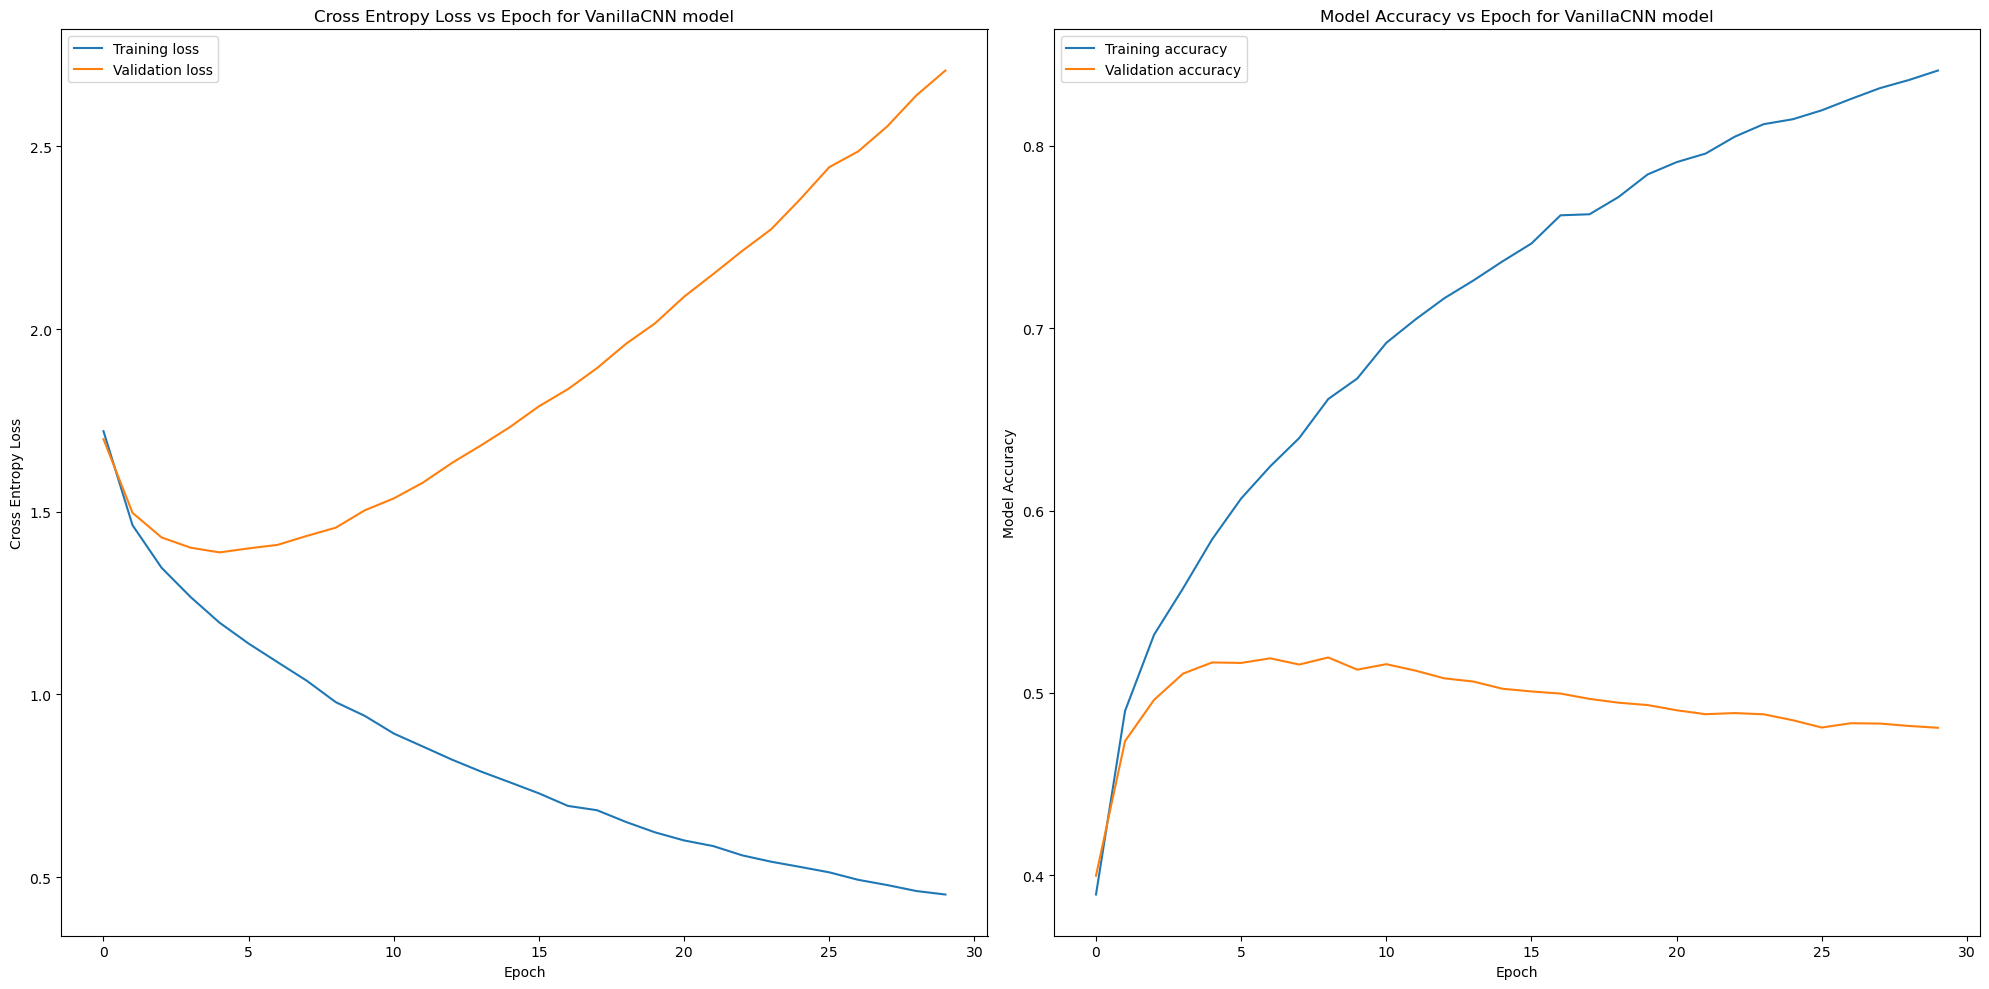

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))  # 1 row, 2 columns

# Cross Entropy Loss vs Epoch for Linear model
axs[0].plot(train_loss_van, label='Training loss')
axs[0].plot(val_loss_van, label='Validation loss')
axs[0].set_title('Cross Entropy Loss vs Epoch for VanillaCNN model')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Cross Entropy Loss')
axs[0].legend()

# Model Accuracy vs Epoch for Linear model
axs[1].plot(train_acc_van, label='Training accuracy')
axs[1].plot(val_acc_van, label='Validation accuracy')
axs[1].set_title('Model Accuracy vs Epoch for VanillaCNN model')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Model Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()


## Q10. Tune the VanillaCNN model by adding batchnorm, more layers, better activations, improved learning rates and dropouts. Also, compare the accuracy of the linear model, the simple conv net and the tuned conv net. 

In [7]:
if __name__ == '__main__':

    # Define the saving path for trained models
    save_path = "./LinearModel/"
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # Check device availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # initialize a model
    model_linear = LinearModel()
    epochs = 10
    batch_size = 128
    learning_rate = 0.001
    weight_decay = 0.0002

    # train the model
    model, best_model_save_path, device, train_acc_lin, val_acc_lin, train_loss_lin, val_loss_lin = training_loop(
        model=model_linear,
        dataset_train=dataset_train,
        dataset_val=dataset_val,
        epochs=epochs,
        batch_size=batch_size,
        lr=learning_rate,
        weight_decay=weight_decay,
        save_path="./LinearModel/",
        model_name_str='LinearModel',  # you should change this to the specific model name you are training
        device=device)


Training model:  LinearModel


  0%|          | 0/10 [00:00<?, ?it/s]

-------------------- Begin Epoch 0 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 0, Batch 20: New best val acc 0.213, model weights saved to ./LinearModel/E0B20_LinearModel.pt
Epoch 0, Batch 60: New best val acc 0.218, model weights saved to ./LinearModel/E0B60_LinearModel.pt
Epoch 0, Batch 80: New best val acc 0.227, model weights saved to ./LinearModel/E0B80_LinearModel.pt
Epoch 0, Batch 100: New best val acc 0.229, model weights saved to ./LinearModel/E0B100_LinearModel.pt
Epoch 0, Batch 120: New best val acc 0.242, model weights saved to ./LinearModel/E0B120_LinearModel.pt
Epoch 0, Batch 160: New best val acc 0.246, model weights saved to ./LinearModel/E0B160_LinearModel.pt
Epoch 0, Batch 240: New best val acc 0.261, model weights saved to ./LinearModel/E0B240_LinearModel.pt
End of Epoch 0: train loss 2.638, val loss 2.556; train acc 0.226, val acc 0.232
Current total training time: 5.606 seconds; time for this epoch: 5.590 seconds
-------------------------------------------------------
-------------------- Begin Epoch 1 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 1, Batch 20: New best val acc 0.224, model weights saved to ./LinearModel/E1B20_LinearModel.pt
Epoch 1, Batch 40: New best val acc 0.230, model weights saved to ./LinearModel/E1B40_LinearModel.pt
Epoch 1, Batch 100: New best val acc 0.250, model weights saved to ./LinearModel/E1B100_LinearModel.pt
Epoch 1, Batch 240: New best val acc 0.251, model weights saved to ./LinearModel/E1B240_LinearModel.pt
End of Epoch 1: train loss 2.467, val loss 2.591; train acc 0.264, val acc 0.237
Current total training time: 10.162 seconds; time for this epoch: 4.555 seconds
-------------------------------------------------------
-------------------- Begin Epoch 2 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 2, Batch 20: New best val acc 0.232, model weights saved to ./LinearModel/E2B20_LinearModel.pt
Epoch 2, Batch 40: New best val acc 0.245, model weights saved to ./LinearModel/E2B40_LinearModel.pt
Epoch 2, Batch 60: New best val acc 0.248, model weights saved to ./LinearModel/E2B60_LinearModel.pt
Epoch 2, Batch 80: New best val acc 0.253, model weights saved to ./LinearModel/E2B80_LinearModel.pt
Epoch 2, Batch 300: New best val acc 0.263, model weights saved to ./LinearModel/E2B300_LinearModel.pt
End of Epoch 2: train loss 2.367, val loss 2.538; train acc 0.279, val acc 0.242
Current total training time: 15.067 seconds; time for this epoch: 4.905 seconds
-------------------------------------------------------
-------------------- Begin Epoch 3 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 3, Batch 20: New best val acc 0.227, model weights saved to ./LinearModel/E3B20_LinearModel.pt
Epoch 3, Batch 40: New best val acc 0.239, model weights saved to ./LinearModel/E3B40_LinearModel.pt
Epoch 3, Batch 60: New best val acc 0.256, model weights saved to ./LinearModel/E3B60_LinearModel.pt
End of Epoch 3: train loss 2.372, val loss 2.599; train acc 0.290, val acc 0.241
Current total training time: 19.713 seconds; time for this epoch: 4.644 seconds
-------------------------------------------------------
-------------------- Begin Epoch 4 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 4, Batch 20: New best val acc 0.253, model weights saved to ./LinearModel/E4B20_LinearModel.pt
Epoch 4, Batch 60: New best val acc 0.253, model weights saved to ./LinearModel/E4B60_LinearModel.pt
Epoch 4, Batch 260: New best val acc 0.258, model weights saved to ./LinearModel/E4B260_LinearModel.pt
End of Epoch 4: train loss 2.283, val loss 2.580; train acc 0.303, val acc 0.240
Current total training time: 24.243 seconds; time for this epoch: 4.529 seconds
-------------------------------------------------------
-------------------- Begin Epoch 5 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 5, Batch 20: New best val acc 0.239, model weights saved to ./LinearModel/E5B20_LinearModel.pt
Epoch 5, Batch 40: New best val acc 0.242, model weights saved to ./LinearModel/E5B40_LinearModel.pt
Epoch 5, Batch 60: New best val acc 0.248, model weights saved to ./LinearModel/E5B60_LinearModel.pt
Epoch 5, Batch 100: New best val acc 0.261, model weights saved to ./LinearModel/E5B100_LinearModel.pt
End of Epoch 5: train loss 2.266, val loss 2.624; train acc 0.312, val acc 0.242
Current total training time: 28.910 seconds; time for this epoch: 4.665 seconds
-------------------------------------------------------
-------------------- Begin Epoch 6 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 6, Batch 20: New best val acc 0.226, model weights saved to ./LinearModel/E6B20_LinearModel.pt
Epoch 6, Batch 40: New best val acc 0.240, model weights saved to ./LinearModel/E6B40_LinearModel.pt
Epoch 6, Batch 140: New best val acc 0.257, model weights saved to ./LinearModel/E6B140_LinearModel.pt
Epoch 6, Batch 240: New best val acc 0.258, model weights saved to ./LinearModel/E6B240_LinearModel.pt
Epoch 6, Batch 300: New best val acc 0.258, model weights saved to ./LinearModel/E6B300_LinearModel.pt
End of Epoch 6: train loss 2.259, val loss 2.626; train acc 0.317, val acc 0.241
Current total training time: 33.451 seconds; time for this epoch: 4.540 seconds
-------------------------------------------------------
-------------------- Begin Epoch 7 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 7, Batch 20: New best val acc 0.243, model weights saved to ./LinearModel/E7B20_LinearModel.pt
Epoch 7, Batch 60: New best val acc 0.250, model weights saved to ./LinearModel/E7B60_LinearModel.pt
Epoch 7, Batch 140: New best val acc 0.250, model weights saved to ./LinearModel/E7B140_LinearModel.pt
Epoch 7, Batch 200: New best val acc 0.253, model weights saved to ./LinearModel/E7B200_LinearModel.pt
Epoch 7, Batch 240: New best val acc 0.257, model weights saved to ./LinearModel/E7B240_LinearModel.pt
Epoch 7, Batch 340: New best val acc 0.257, model weights saved to ./LinearModel/E7B340_LinearModel.pt
End of Epoch 7: train loss 2.277, val loss 2.700; train acc 0.318, val acc 0.240
Current total training time: 38.062 seconds; time for this epoch: 4.610 seconds
-------------------------------------------------------
-------------------- Begin Epoch 8 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 8, Batch 20: New best val acc 0.236, model weights saved to ./LinearModel/E8B20_LinearModel.pt
Epoch 8, Batch 40: New best val acc 0.238, model weights saved to ./LinearModel/E8B40_LinearModel.pt
Epoch 8, Batch 60: New best val acc 0.245, model weights saved to ./LinearModel/E8B60_LinearModel.pt
Epoch 8, Batch 100: New best val acc 0.247, model weights saved to ./LinearModel/E8B100_LinearModel.pt
Epoch 8, Batch 120: New best val acc 0.248, model weights saved to ./LinearModel/E8B120_LinearModel.pt
Epoch 8, Batch 180: New best val acc 0.253, model weights saved to ./LinearModel/E8B180_LinearModel.pt
Epoch 8, Batch 260: New best val acc 0.260, model weights saved to ./LinearModel/E8B260_LinearModel.pt
End of Epoch 8: train loss 2.250, val loss 2.738; train acc 0.326, val acc 0.240
Current total training time: 42.771 seconds; time for this epoch: 4.708 seconds
-------------------------------------------------------
-------------------- Begin Epoch 9 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 9, Batch 20: New best val acc 0.247, model weights saved to ./LinearModel/E9B20_LinearModel.pt
Epoch 9, Batch 140: New best val acc 0.252, model weights saved to ./LinearModel/E9B140_LinearModel.pt
Epoch 9, Batch 160: New best val acc 0.255, model weights saved to ./LinearModel/E9B160_LinearModel.pt
Epoch 9, Batch 300: New best val acc 0.264, model weights saved to ./LinearModel/E9B300_LinearModel.pt
End of Epoch 9: train loss 2.218, val loss 2.659; train acc 0.331, val acc 0.245
Current total training time: 47.733 seconds; time for this epoch: 4.961 seconds
-------------------------------------------------------


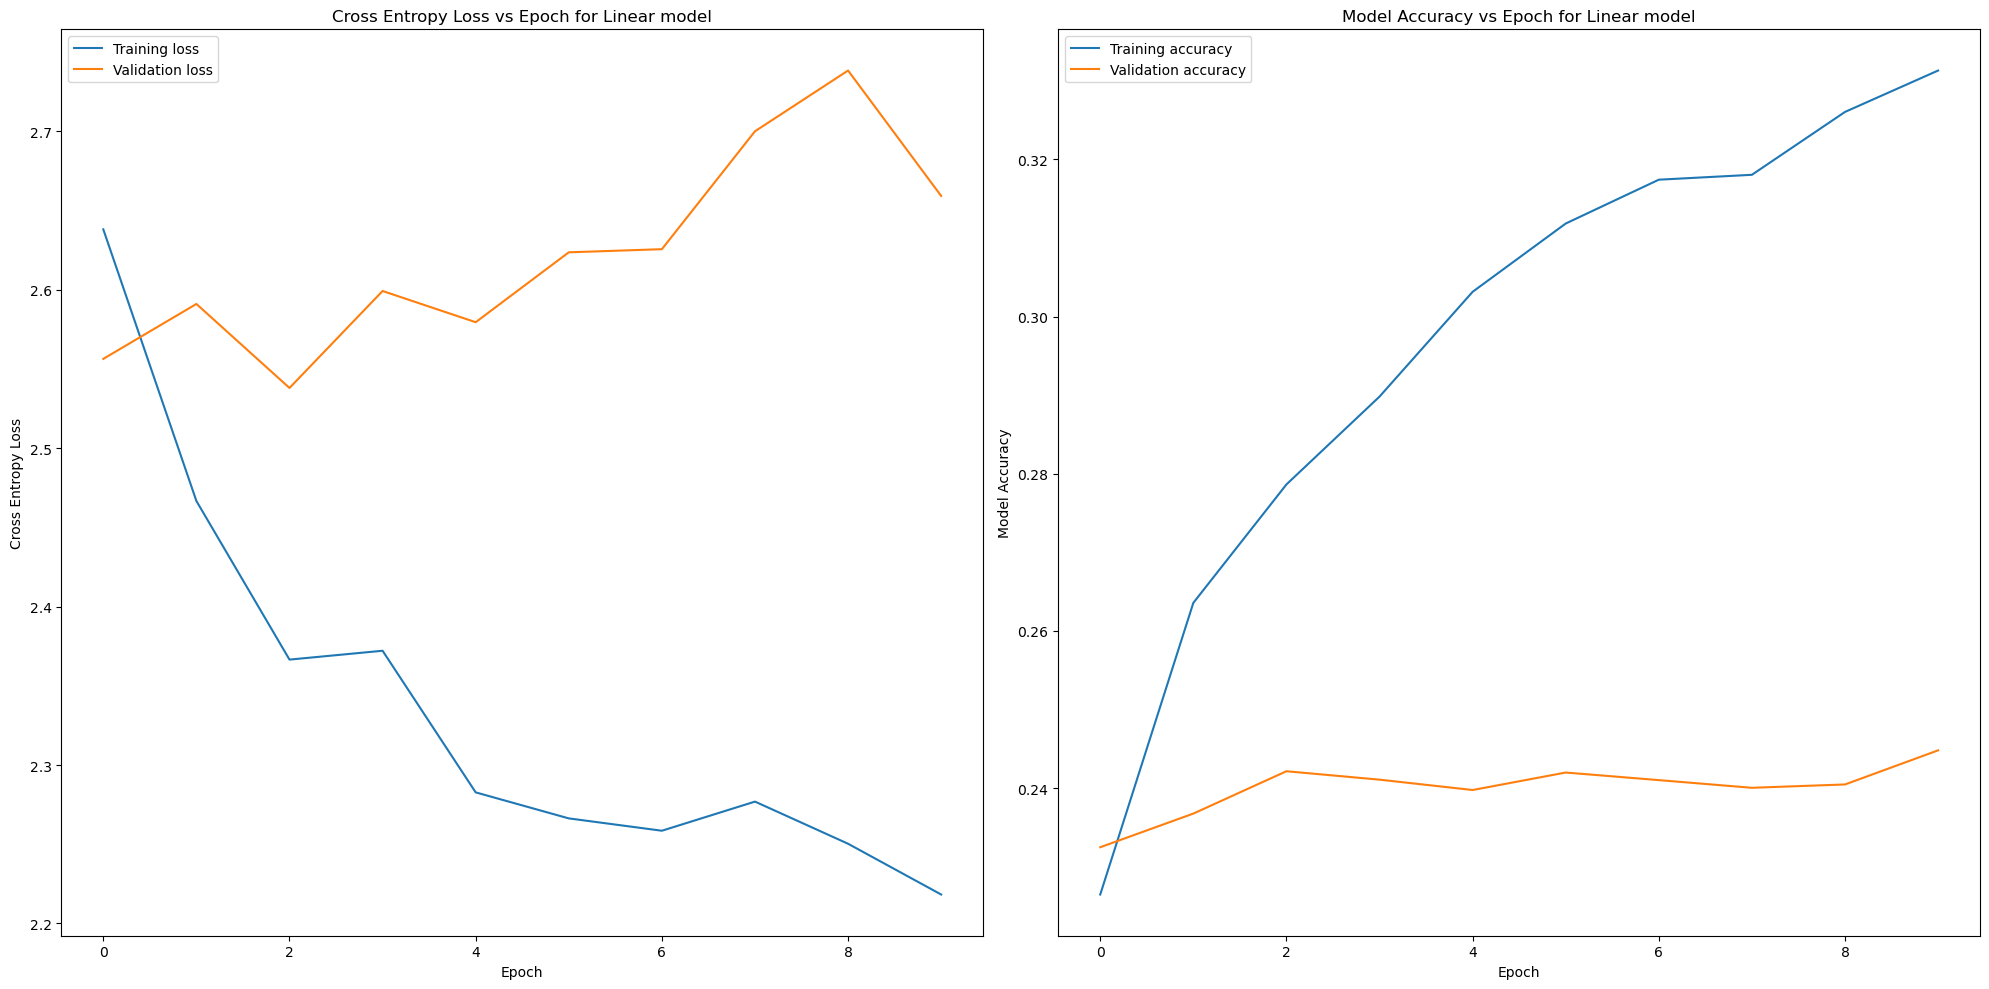

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))  # 1 row, 2 columns

# Cross Entropy Loss vs Epoch for Linear model
axs[0].plot(train_loss_lin, label='Training loss')
axs[0].plot(val_loss_lin, label='Validation loss')
axs[0].set_title('Cross Entropy Loss vs Epoch for Linear model')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Cross Entropy Loss')
axs[0].legend()

# Model Accuracy vs Epoch for Linear model
axs[1].plot(train_acc_lin, label='Training accuracy')
axs[1].plot(val_acc_lin, label='Validation accuracy')
axs[1].set_title('Model Accuracy vs Epoch for Linear model')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Model Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()


In [9]:
class TunedCNN(nn.Module):
    def __init__(self):
        super(TunedCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x))))
        
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

if __name__ == '__main__':

    # Define the saving path for trained models
    save_path = "./TunedCNN/"
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # Check device availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # initialize a model
    model_tune = TunedCNN()
    epochs = 30
    batch_size = 128
    learning_rate = 0.001
    weight_decay = 0.0001

    # train the model
    model, best_model_save_path, device, train_acc_tune, val_acc_tune, train_loss_tune, val_loss_tune = training_loop(
        model=model_tune,
        dataset_train=dataset_train,
        dataset_val=dataset_val,
        epochs=epochs,
        batch_size=batch_size,
        lr=learning_rate,
        weight_decay=weight_decay,
        save_path="./TunedCNN/",
        model_name_str='TunedCNN',  # you should change this to the specific model name you are training
        device=device)


Training model:  TunedCNN


  0%|          | 0/30 [00:00<?, ?it/s]

-------------------- Begin Epoch 0 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 0, Batch 20: New best val acc 0.255, model weights saved to ./TunedCNN/E0B20_TunedCNN.pt
Epoch 0, Batch 40: New best val acc 0.365, model weights saved to ./TunedCNN/E0B40_TunedCNN.pt
Epoch 0, Batch 60: New best val acc 0.373, model weights saved to ./TunedCNN/E0B60_TunedCNN.pt
Epoch 0, Batch 80: New best val acc 0.397, model weights saved to ./TunedCNN/E0B80_TunedCNN.pt
Epoch 0, Batch 100: New best val acc 0.436, model weights saved to ./TunedCNN/E0B100_TunedCNN.pt
Epoch 0, Batch 180: New best val acc 0.440, model weights saved to ./TunedCNN/E0B180_TunedCNN.pt
Epoch 0, Batch 220: New best val acc 0.468, model weights saved to ./TunedCNN/E0B220_TunedCNN.pt
Epoch 0, Batch 260: New best val acc 0.479, model weights saved to ./TunedCNN/E0B260_TunedCNN.pt
Epoch 0, Batch 280: New best val acc 0.485, model weights saved to ./TunedCNN/E0B280_TunedCNN.pt
Epoch 0, Batch 300: New best val acc 0.488, model weights saved to ./TunedCNN/E0B300_TunedCNN.pt
End of Epoch 0: train loss 1.584, val 

  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 1, Batch 20: New best val acc 0.523, model weights saved to ./TunedCNN/E1B20_TunedCNN.pt
Epoch 1, Batch 100: New best val acc 0.525, model weights saved to ./TunedCNN/E1B100_TunedCNN.pt
Epoch 1, Batch 160: New best val acc 0.537, model weights saved to ./TunedCNN/E1B160_TunedCNN.pt
Epoch 1, Batch 280: New best val acc 0.540, model weights saved to ./TunedCNN/E1B280_TunedCNN.pt
End of Epoch 1: train loss 1.292, val loss 1.367; train acc 0.534, val acc 0.514
Current total training time: 32.375 seconds; time for this epoch: 16.071 seconds
-------------------------------------------------------
-------------------- Begin Epoch 2 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 2, Batch 20: New best val acc 0.531, model weights saved to ./TunedCNN/E2B20_TunedCNN.pt
Epoch 2, Batch 60: New best val acc 0.536, model weights saved to ./TunedCNN/E2B60_TunedCNN.pt
Epoch 2, Batch 100: New best val acc 0.563, model weights saved to ./TunedCNN/E2B100_TunedCNN.pt
Epoch 2, Batch 200: New best val acc 0.563, model weights saved to ./TunedCNN/E2B200_TunedCNN.pt
Epoch 2, Batch 260: New best val acc 0.566, model weights saved to ./TunedCNN/E2B260_TunedCNN.pt
Epoch 2, Batch 340: New best val acc 0.572, model weights saved to ./TunedCNN/E2B340_TunedCNN.pt
End of Epoch 2: train loss 1.167, val loss 1.282; train acc 0.580, val acc 0.546
Current total training time: 48.370 seconds; time for this epoch: 15.994 seconds
-------------------------------------------------------
-------------------- Begin Epoch 3 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 3, Batch 20: New best val acc 0.565, model weights saved to ./TunedCNN/E3B20_TunedCNN.pt
Epoch 3, Batch 40: New best val acc 0.576, model weights saved to ./TunedCNN/E3B40_TunedCNN.pt
Epoch 3, Batch 140: New best val acc 0.578, model weights saved to ./TunedCNN/E3B140_TunedCNN.pt
Epoch 3, Batch 160: New best val acc 0.583, model weights saved to ./TunedCNN/E3B160_TunedCNN.pt
Epoch 3, Batch 180: New best val acc 0.593, model weights saved to ./TunedCNN/E3B180_TunedCNN.pt
End of Epoch 3: train loss 1.063, val loss 1.247; train acc 0.616, val acc 0.564
Current total training time: 64.427 seconds; time for this epoch: 16.056 seconds
-------------------------------------------------------
-------------------- Begin Epoch 4 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 4, Batch 20: New best val acc 0.593, model weights saved to ./TunedCNN/E4B20_TunedCNN.pt
Epoch 4, Batch 80: New best val acc 0.604, model weights saved to ./TunedCNN/E4B80_TunedCNN.pt
Epoch 4, Batch 120: New best val acc 0.606, model weights saved to ./TunedCNN/E4B120_TunedCNN.pt
Epoch 4, Batch 340: New best val acc 0.609, model weights saved to ./TunedCNN/E4B340_TunedCNN.pt
End of Epoch 4: train loss 0.967, val loss 1.184; train acc 0.651, val acc 0.588
Current total training time: 80.337 seconds; time for this epoch: 15.909 seconds
-------------------------------------------------------
-------------------- Begin Epoch 5 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 5, Batch 20: New best val acc 0.549, model weights saved to ./TunedCNN/E5B20_TunedCNN.pt
Epoch 5, Batch 40: New best val acc 0.620, model weights saved to ./TunedCNN/E5B40_TunedCNN.pt
Epoch 5, Batch 100: New best val acc 0.633, model weights saved to ./TunedCNN/E5B100_TunedCNN.pt
Epoch 5, Batch 120: New best val acc 0.638, model weights saved to ./TunedCNN/E5B120_TunedCNN.pt
End of Epoch 5: train loss 0.879, val loss 1.139; train acc 0.683, val acc 0.608
Current total training time: 96.291 seconds; time for this epoch: 15.953 seconds
-------------------------------------------------------
-------------------- Begin Epoch 6 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 6, Batch 20: New best val acc 0.636, model weights saved to ./TunedCNN/E6B20_TunedCNN.pt
End of Epoch 6: train loss 0.798, val loss 1.107; train acc 0.711, val acc 0.620
Current total training time: 112.262 seconds; time for this epoch: 15.971 seconds
-------------------------------------------------------
-------------------- Begin Epoch 7 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 7, Batch 20: New best val acc 0.635, model weights saved to ./TunedCNN/E7B20_TunedCNN.pt
Epoch 7, Batch 60: New best val acc 0.653, model weights saved to ./TunedCNN/E7B60_TunedCNN.pt
Epoch 7, Batch 320: New best val acc 0.657, model weights saved to ./TunedCNN/E7B320_TunedCNN.pt
End of Epoch 7: train loss 0.716, val loss 1.103; train acc 0.740, val acc 0.627
Current total training time: 128.289 seconds; time for this epoch: 16.026 seconds
-------------------------------------------------------
-------------------- Begin Epoch 8 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 8, Batch 20: New best val acc 0.635, model weights saved to ./TunedCNN/E8B20_TunedCNN.pt
Epoch 8, Batch 60: New best val acc 0.651, model weights saved to ./TunedCNN/E8B60_TunedCNN.pt
Epoch 8, Batch 80: New best val acc 0.654, model weights saved to ./TunedCNN/E8B80_TunedCNN.pt
Epoch 8, Batch 160: New best val acc 0.662, model weights saved to ./TunedCNN/E8B160_TunedCNN.pt
End of Epoch 8: train loss 0.629, val loss 1.113; train acc 0.770, val acc 0.632
Current total training time: 144.306 seconds; time for this epoch: 16.016 seconds
-------------------------------------------------------
-------------------- Begin Epoch 9 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 9, Batch 20: New best val acc 0.644, model weights saved to ./TunedCNN/E9B20_TunedCNN.pt
Epoch 9, Batch 40: New best val acc 0.646, model weights saved to ./TunedCNN/E9B40_TunedCNN.pt
Epoch 9, Batch 220: New best val acc 0.650, model weights saved to ./TunedCNN/E9B220_TunedCNN.pt
End of Epoch 9: train loss 0.547, val loss 1.156; train acc 0.799, val acc 0.632
Current total training time: 160.297 seconds; time for this epoch: 15.990 seconds
-------------------------------------------------------
-------------------- Begin Epoch 10 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 10, Batch 20: New best val acc 0.640, model weights saved to ./TunedCNN/E10B20_TunedCNN.pt
Epoch 10, Batch 120: New best val acc 0.651, model weights saved to ./TunedCNN/E10B120_TunedCNN.pt
Epoch 10, Batch 260: New best val acc 0.656, model weights saved to ./TunedCNN/E10B260_TunedCNN.pt
End of Epoch 10: train loss 0.462, val loss 1.206; train acc 0.830, val acc 0.633
Current total training time: 176.267 seconds; time for this epoch: 15.969 seconds
-------------------------------------------------------
-------------------- Begin Epoch 11 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 11, Batch 20: New best val acc 0.652, model weights saved to ./TunedCNN/E11B20_TunedCNN.pt
Epoch 11, Batch 180: New best val acc 0.653, model weights saved to ./TunedCNN/E11B180_TunedCNN.pt
End of Epoch 11: train loss 0.390, val loss 1.242; train acc 0.857, val acc 0.637
Current total training time: 192.258 seconds; time for this epoch: 15.990 seconds
-------------------------------------------------------
-------------------- Begin Epoch 12 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 12, Batch 20: New best val acc 0.646, model weights saved to ./TunedCNN/E12B20_TunedCNN.pt
Epoch 12, Batch 40: New best val acc 0.648, model weights saved to ./TunedCNN/E12B40_TunedCNN.pt
Epoch 12, Batch 140: New best val acc 0.655, model weights saved to ./TunedCNN/E12B140_TunedCNN.pt
End of Epoch 12: train loss 0.312, val loss 1.296; train acc 0.886, val acc 0.640
Current total training time: 208.284 seconds; time for this epoch: 16.025 seconds
-------------------------------------------------------
-------------------- Begin Epoch 13 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 13, Batch 20: New best val acc 0.634, model weights saved to ./TunedCNN/E13B20_TunedCNN.pt
Epoch 13, Batch 40: New best val acc 0.638, model weights saved to ./TunedCNN/E13B40_TunedCNN.pt
Epoch 13, Batch 60: New best val acc 0.644, model weights saved to ./TunedCNN/E13B60_TunedCNN.pt
Epoch 13, Batch 80: New best val acc 0.648, model weights saved to ./TunedCNN/E13B80_TunedCNN.pt
Epoch 13, Batch 160: New best val acc 0.652, model weights saved to ./TunedCNN/E13B160_TunedCNN.pt
Epoch 13, Batch 240: New best val acc 0.657, model weights saved to ./TunedCNN/E13B240_TunedCNN.pt
End of Epoch 13: train loss 0.267, val loss 1.394; train acc 0.903, val acc 0.638
Current total training time: 224.392 seconds; time for this epoch: 16.107 seconds
-------------------------------------------------------
-------------------- Begin Epoch 14 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 14, Batch 20: New best val acc 0.642, model weights saved to ./TunedCNN/E14B20_TunedCNN.pt
Epoch 14, Batch 60: New best val acc 0.649, model weights saved to ./TunedCNN/E14B60_TunedCNN.pt
Epoch 14, Batch 140: New best val acc 0.651, model weights saved to ./TunedCNN/E14B140_TunedCNN.pt
End of Epoch 14: train loss 0.213, val loss 1.452; train acc 0.926, val acc 0.637
Current total training time: 240.412 seconds; time for this epoch: 16.019 seconds
-------------------------------------------------------
-------------------- Begin Epoch 15 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 15, Batch 20: New best val acc 0.647, model weights saved to ./TunedCNN/E15B20_TunedCNN.pt
Epoch 15, Batch 40: New best val acc 0.648, model weights saved to ./TunedCNN/E15B40_TunedCNN.pt
End of Epoch 15: train loss 0.181, val loss 1.531; train acc 0.938, val acc 0.639
Current total training time: 256.415 seconds; time for this epoch: 16.002 seconds
-------------------------------------------------------
-------------------- Begin Epoch 16 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 16, Batch 20: New best val acc 0.643, model weights saved to ./TunedCNN/E16B20_TunedCNN.pt
Epoch 16, Batch 80: New best val acc 0.645, model weights saved to ./TunedCNN/E16B80_TunedCNN.pt
Epoch 16, Batch 140: New best val acc 0.647, model weights saved to ./TunedCNN/E16B140_TunedCNN.pt
Epoch 16, Batch 160: New best val acc 0.653, model weights saved to ./TunedCNN/E16B160_TunedCNN.pt
End of Epoch 16: train loss 0.164, val loss 1.593; train acc 0.945, val acc 0.639
Current total training time: 272.401 seconds; time for this epoch: 15.986 seconds
-------------------------------------------------------
-------------------- Begin Epoch 17 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 17, Batch 20: New best val acc 0.637, model weights saved to ./TunedCNN/E17B20_TunedCNN.pt
Epoch 17, Batch 140: New best val acc 0.639, model weights saved to ./TunedCNN/E17B140_TunedCNN.pt
Epoch 17, Batch 200: New best val acc 0.640, model weights saved to ./TunedCNN/E17B200_TunedCNN.pt
Epoch 17, Batch 220: New best val acc 0.643, model weights saved to ./TunedCNN/E17B220_TunedCNN.pt
Epoch 17, Batch 240: New best val acc 0.649, model weights saved to ./TunedCNN/E17B240_TunedCNN.pt
End of Epoch 17: train loss 0.161, val loss 1.650; train acc 0.945, val acc 0.635
Current total training time: 288.474 seconds; time for this epoch: 16.072 seconds
-------------------------------------------------------
-------------------- Begin Epoch 18 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 18, Batch 20: New best val acc 0.651, model weights saved to ./TunedCNN/E18B20_TunedCNN.pt
End of Epoch 18: train loss 0.130, val loss 1.661; train acc 0.960, val acc 0.639
Current total training time: 304.421 seconds; time for this epoch: 15.946 seconds
-------------------------------------------------------
-------------------- Begin Epoch 19 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 19, Batch 20: New best val acc 0.655, model weights saved to ./TunedCNN/E19B20_TunedCNN.pt
Epoch 19, Batch 60: New best val acc 0.657, model weights saved to ./TunedCNN/E19B60_TunedCNN.pt
End of Epoch 19: train loss 0.128, val loss 1.699; train acc 0.960, val acc 0.645
Current total training time: 320.444 seconds; time for this epoch: 16.023 seconds
-------------------------------------------------------
-------------------- Begin Epoch 20 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 20, Batch 20: New best val acc 0.624, model weights saved to ./TunedCNN/E20B20_TunedCNN.pt
Epoch 20, Batch 40: New best val acc 0.626, model weights saved to ./TunedCNN/E20B40_TunedCNN.pt
Epoch 20, Batch 60: New best val acc 0.639, model weights saved to ./TunedCNN/E20B60_TunedCNN.pt
Epoch 20, Batch 140: New best val acc 0.645, model weights saved to ./TunedCNN/E20B140_TunedCNN.pt
Epoch 20, Batch 280: New best val acc 0.647, model weights saved to ./TunedCNN/E20B280_TunedCNN.pt
End of Epoch 20: train loss 0.138, val loss 1.789; train acc 0.956, val acc 0.631
Current total training time: 336.455 seconds; time for this epoch: 16.010 seconds
-------------------------------------------------------
-------------------- Begin Epoch 21 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 21, Batch 20: New best val acc 0.642, model weights saved to ./TunedCNN/E21B20_TunedCNN.pt
Epoch 21, Batch 60: New best val acc 0.647, model weights saved to ./TunedCNN/E21B60_TunedCNN.pt
Epoch 21, Batch 160: New best val acc 0.653, model weights saved to ./TunedCNN/E21B160_TunedCNN.pt
End of Epoch 21: train loss 0.120, val loss 1.707; train acc 0.963, val acc 0.644
Current total training time: 352.523 seconds; time for this epoch: 16.067 seconds
-------------------------------------------------------
-------------------- Begin Epoch 22 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 22, Batch 20: New best val acc 0.646, model weights saved to ./TunedCNN/E22B20_TunedCNN.pt
Epoch 22, Batch 40: New best val acc 0.647, model weights saved to ./TunedCNN/E22B40_TunedCNN.pt
Epoch 22, Batch 60: New best val acc 0.651, model weights saved to ./TunedCNN/E22B60_TunedCNN.pt
Epoch 22, Batch 80: New best val acc 0.653, model weights saved to ./TunedCNN/E22B80_TunedCNN.pt
Epoch 22, Batch 140: New best val acc 0.654, model weights saved to ./TunedCNN/E22B140_TunedCNN.pt
End of Epoch 22: train loss 0.110, val loss 1.755; train acc 0.967, val acc 0.638
Current total training time: 368.530 seconds; time for this epoch: 16.006 seconds
-------------------------------------------------------
-------------------- Begin Epoch 23 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 23, Batch 20: New best val acc 0.642, model weights saved to ./TunedCNN/E23B20_TunedCNN.pt
Epoch 23, Batch 60: New best val acc 0.642, model weights saved to ./TunedCNN/E23B60_TunedCNN.pt
Epoch 23, Batch 80: New best val acc 0.646, model weights saved to ./TunedCNN/E23B80_TunedCNN.pt
Epoch 23, Batch 120: New best val acc 0.650, model weights saved to ./TunedCNN/E23B120_TunedCNN.pt
End of Epoch 23: train loss 0.120, val loss 1.796; train acc 0.963, val acc 0.636
Current total training time: 384.552 seconds; time for this epoch: 16.022 seconds
-------------------------------------------------------
-------------------- Begin Epoch 24 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 24, Batch 20: New best val acc 0.626, model weights saved to ./TunedCNN/E24B20_TunedCNN.pt
Epoch 24, Batch 40: New best val acc 0.642, model weights saved to ./TunedCNN/E24B40_TunedCNN.pt
Epoch 24, Batch 80: New best val acc 0.645, model weights saved to ./TunedCNN/E24B80_TunedCNN.pt
End of Epoch 24: train loss 0.115, val loss 1.780; train acc 0.964, val acc 0.638
Current total training time: 400.504 seconds; time for this epoch: 15.951 seconds
-------------------------------------------------------
-------------------- Begin Epoch 25 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 25, Batch 20: New best val acc 0.640, model weights saved to ./TunedCNN/E25B20_TunedCNN.pt
Epoch 25, Batch 40: New best val acc 0.648, model weights saved to ./TunedCNN/E25B40_TunedCNN.pt
Epoch 25, Batch 80: New best val acc 0.655, model weights saved to ./TunedCNN/E25B80_TunedCNN.pt
End of Epoch 25: train loss 0.100, val loss 1.773; train acc 0.968, val acc 0.643
Current total training time: 416.569 seconds; time for this epoch: 16.064 seconds
-------------------------------------------------------
-------------------- Begin Epoch 26 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 26, Batch 20: New best val acc 0.639, model weights saved to ./TunedCNN/E26B20_TunedCNN.pt
Epoch 26, Batch 60: New best val acc 0.651, model weights saved to ./TunedCNN/E26B60_TunedCNN.pt
Epoch 26, Batch 80: New best val acc 0.652, model weights saved to ./TunedCNN/E26B80_TunedCNN.pt
End of Epoch 26: train loss 0.098, val loss 1.817; train acc 0.970, val acc 0.641
Current total training time: 432.513 seconds; time for this epoch: 15.944 seconds
-------------------------------------------------------
-------------------- Begin Epoch 27 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 27, Batch 20: New best val acc 0.622, model weights saved to ./TunedCNN/E27B20_TunedCNN.pt
Epoch 27, Batch 40: New best val acc 0.649, model weights saved to ./TunedCNN/E27B40_TunedCNN.pt
End of Epoch 27: train loss 0.102, val loss 1.883; train acc 0.968, val acc 0.635
Current total training time: 448.476 seconds; time for this epoch: 15.962 seconds
-------------------------------------------------------
-------------------- Begin Epoch 28 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 28, Batch 20: New best val acc 0.590, model weights saved to ./TunedCNN/E28B20_TunedCNN.pt
Epoch 28, Batch 40: New best val acc 0.630, model weights saved to ./TunedCNN/E28B40_TunedCNN.pt
Epoch 28, Batch 60: New best val acc 0.640, model weights saved to ./TunedCNN/E28B60_TunedCNN.pt
Epoch 28, Batch 140: New best val acc 0.640, model weights saved to ./TunedCNN/E28B140_TunedCNN.pt
Epoch 28, Batch 160: New best val acc 0.641, model weights saved to ./TunedCNN/E28B160_TunedCNN.pt
Epoch 28, Batch 180: New best val acc 0.646, model weights saved to ./TunedCNN/E28B180_TunedCNN.pt
Epoch 28, Batch 220: New best val acc 0.649, model weights saved to ./TunedCNN/E28B220_TunedCNN.pt
Epoch 28, Batch 320: New best val acc 0.651, model weights saved to ./TunedCNN/E28B320_TunedCNN.pt
End of Epoch 28: train loss 0.106, val loss 1.867; train acc 0.967, val acc 0.636
Current total training time: 464.482 seconds; time for this epoch: 16.006 seconds
--------------------------------------------------

  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 29, Batch 20: New best val acc 0.639, model weights saved to ./TunedCNN/E29B20_TunedCNN.pt
Epoch 29, Batch 60: New best val acc 0.651, model weights saved to ./TunedCNN/E29B60_TunedCNN.pt
Epoch 29, Batch 320: New best val acc 0.655, model weights saved to ./TunedCNN/E29B320_TunedCNN.pt
End of Epoch 29: train loss 0.098, val loss 1.892; train acc 0.969, val acc 0.634
Current total training time: 480.432 seconds; time for this epoch: 15.949 seconds
-------------------------------------------------------


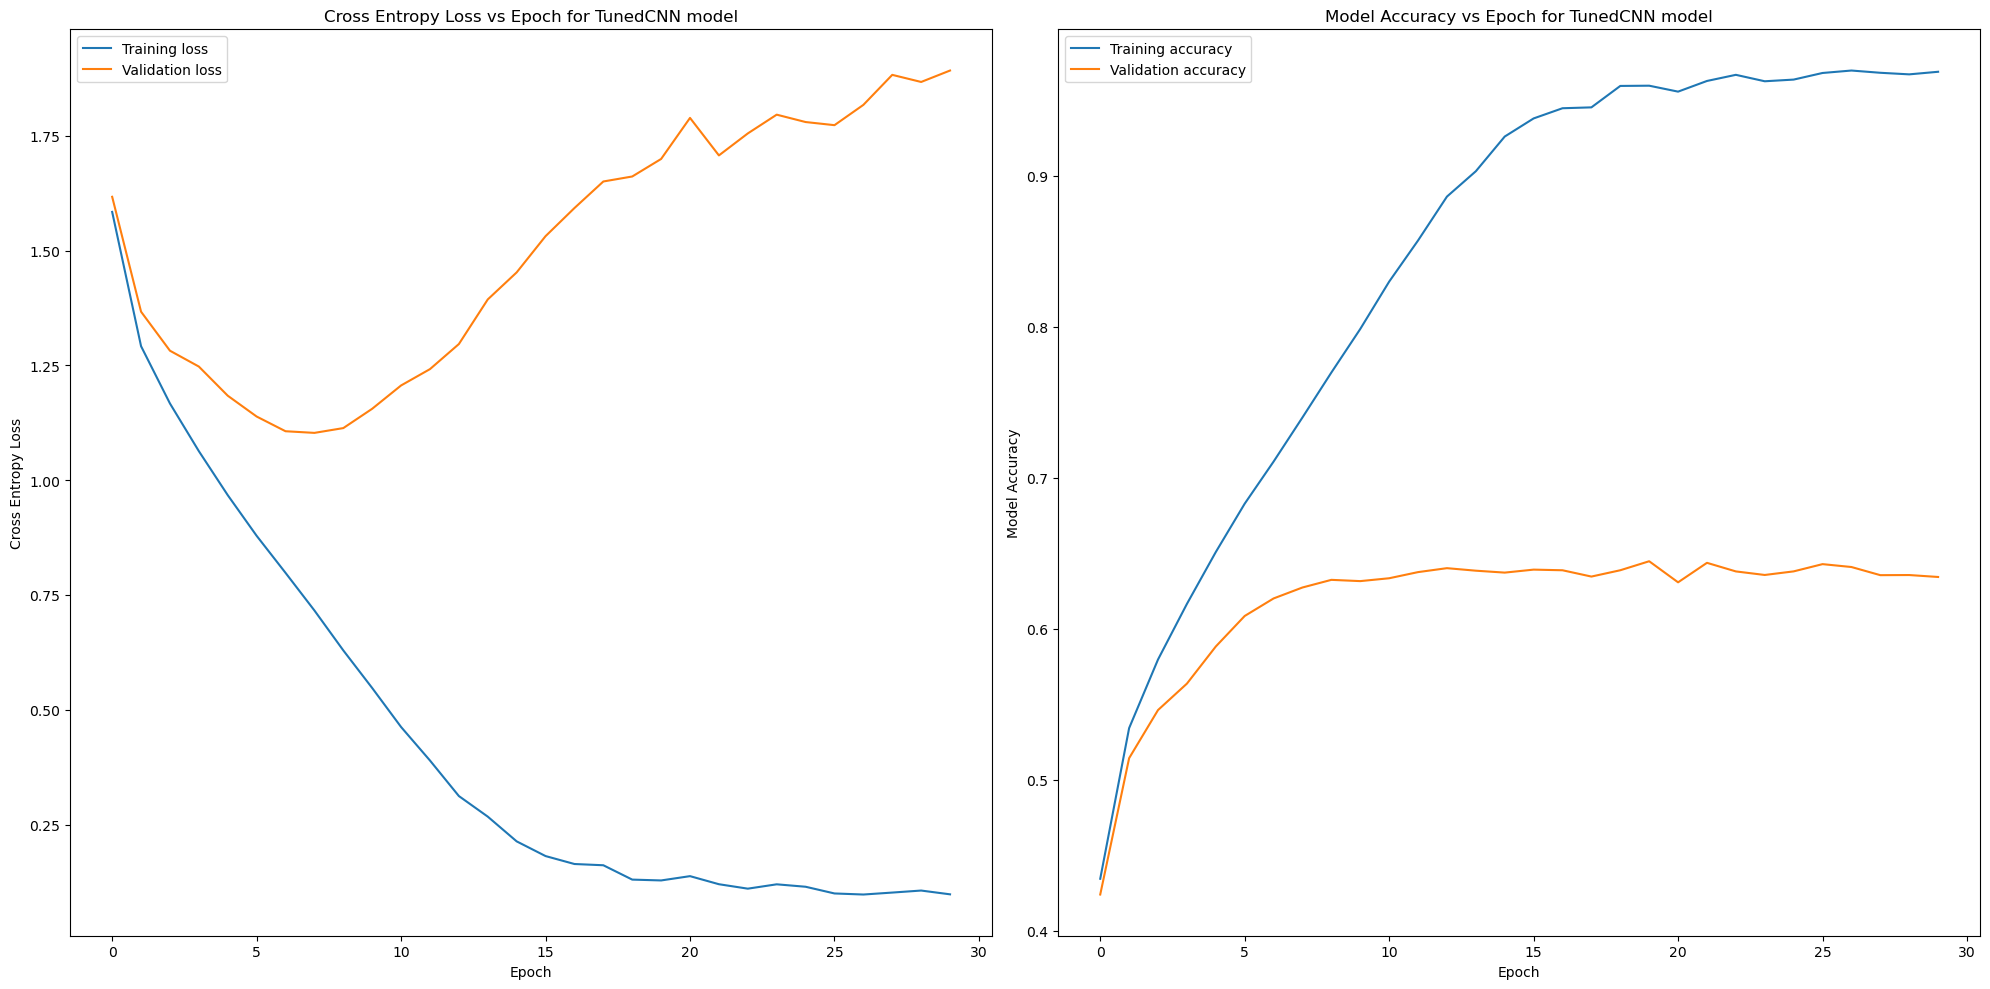

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))  # 1 row, 2 columns

# Cross Entropy Loss vs Epoch for Linear model
axs[0].plot(train_loss_tune, label='Training loss')
axs[0].plot(val_loss_tune, label='Validation loss')
axs[0].set_title('Cross Entropy Loss vs Epoch for TunedCNN model')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Cross Entropy Loss')
axs[0].legend()

# Model Accuracy vs Epoch for Linear model
axs[1].plot(train_acc_tune, label='Training accuracy')
axs[1].plot(val_acc_tune, label='Validation accuracy')
axs[1].set_title('Model Accuracy vs Epoch for TunedCNN model')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Model Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()


In [11]:
class TunedCNN_drop(nn.Module):
    def __init__(self):
        super(TunedCNN_drop, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout2d(0.2)  # Dropout after the second conv layer
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout2 = nn.Dropout2d(0.2)  # Dropout after the fourth conv layer

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.dropout3 = nn.Dropout(0.5)  # Dropout before the last fully connected layer
        
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.dropout1(self.pool(F.leaky_relu(self.bn2(self.conv2(x)))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.dropout2(self.pool(F.leaky_relu(self.bn4(self.conv4(x)))))
        
        x = x.view(x.size(0), -1)
        
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout3(x)  # apply dropout after ReLU
        x = self.fc2(x)
        
        return x

if __name__ == '__main__':

    # Define the saving path for trained models
    save_path = "./TunedCNN_drop/"
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # Check device availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # initialize a model
    model_tune = TunedCNN_drop()
    epochs = 30
    batch_size = 128
    learning_rate = 0.001
    weight_decay = 0.0001

    # train the model
    model, best_model_save_path, device, train_acc_drop, val_acc_drop, train_loss_drop, val_loss_drop = training_loop(
        model=model_tune,
        dataset_train=dataset_train,
        dataset_val=dataset_val,
        epochs=epochs,
        batch_size=batch_size,
        lr=learning_rate,
        weight_decay=weight_decay,
        save_path="./TunedCNN_drop/",
        model_name_str='TunedCNN_drop',  # you should change this to the specific model name you are training
        device=device)

Training model:  TunedCNN_drop


  0%|          | 0/30 [00:00<?, ?it/s]

-------------------- Begin Epoch 0 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 0, Batch 20: New best val acc 0.181, model weights saved to ./TunedCNN_drop/E0B20_TunedCNN_drop.pt
Epoch 0, Batch 40: New best val acc 0.245, model weights saved to ./TunedCNN_drop/E0B40_TunedCNN_drop.pt
Epoch 0, Batch 60: New best val acc 0.283, model weights saved to ./TunedCNN_drop/E0B60_TunedCNN_drop.pt
Epoch 0, Batch 80: New best val acc 0.319, model weights saved to ./TunedCNN_drop/E0B80_TunedCNN_drop.pt
Epoch 0, Batch 100: New best val acc 0.321, model weights saved to ./TunedCNN_drop/E0B100_TunedCNN_drop.pt
Epoch 0, Batch 120: New best val acc 0.350, model weights saved to ./TunedCNN_drop/E0B120_TunedCNN_drop.pt
Epoch 0, Batch 140: New best val acc 0.384, model weights saved to ./TunedCNN_drop/E0B140_TunedCNN_drop.pt
Epoch 0, Batch 160: New best val acc 0.392, model weights saved to ./TunedCNN_drop/E0B160_TunedCNN_drop.pt
Epoch 0, Batch 180: New best val acc 0.407, model weights saved to ./TunedCNN_drop/E0B180_TunedCNN_drop.pt
Epoch 0, Batch 200: New best val acc 0.414, m

  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 1, Batch 20: New best val acc 0.432, model weights saved to ./TunedCNN_drop/E1B20_TunedCNN_drop.pt
Epoch 1, Batch 40: New best val acc 0.443, model weights saved to ./TunedCNN_drop/E1B40_TunedCNN_drop.pt
Epoch 1, Batch 60: New best val acc 0.468, model weights saved to ./TunedCNN_drop/E1B60_TunedCNN_drop.pt
Epoch 1, Batch 120: New best val acc 0.475, model weights saved to ./TunedCNN_drop/E1B120_TunedCNN_drop.pt
Epoch 1, Batch 200: New best val acc 0.476, model weights saved to ./TunedCNN_drop/E1B200_TunedCNN_drop.pt
Epoch 1, Batch 220: New best val acc 0.478, model weights saved to ./TunedCNN_drop/E1B220_TunedCNN_drop.pt
Epoch 1, Batch 240: New best val acc 0.489, model weights saved to ./TunedCNN_drop/E1B240_TunedCNN_drop.pt
Epoch 1, Batch 340: New best val acc 0.495, model weights saved to ./TunedCNN_drop/E1B340_TunedCNN_drop.pt
End of Epoch 1: train loss 1.576, val loss 1.477; train acc 0.434, val acc 0.469
Current total training time: 32.488 seconds; time for this epoch: 16.

  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 2, Batch 20: New best val acc 0.485, model weights saved to ./TunedCNN_drop/E2B20_TunedCNN_drop.pt
Epoch 2, Batch 40: New best val acc 0.485, model weights saved to ./TunedCNN_drop/E2B40_TunedCNN_drop.pt
Epoch 2, Batch 60: New best val acc 0.488, model weights saved to ./TunedCNN_drop/E2B60_TunedCNN_drop.pt
Epoch 2, Batch 80: New best val acc 0.492, model weights saved to ./TunedCNN_drop/E2B80_TunedCNN_drop.pt
Epoch 2, Batch 120: New best val acc 0.505, model weights saved to ./TunedCNN_drop/E2B120_TunedCNN_drop.pt
Epoch 2, Batch 220: New best val acc 0.505, model weights saved to ./TunedCNN_drop/E2B220_TunedCNN_drop.pt
Epoch 2, Batch 240: New best val acc 0.508, model weights saved to ./TunedCNN_drop/E2B240_TunedCNN_drop.pt
Epoch 2, Batch 300: New best val acc 0.511, model weights saved to ./TunedCNN_drop/E2B300_TunedCNN_drop.pt
Epoch 2, Batch 320: New best val acc 0.512, model weights saved to ./TunedCNN_drop/E2B320_TunedCNN_drop.pt
Epoch 2, Batch 340: New best val acc 0.515, m

  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 3, Batch 20: New best val acc 0.511, model weights saved to ./TunedCNN_drop/E3B20_TunedCNN_drop.pt
Epoch 3, Batch 40: New best val acc 0.534, model weights saved to ./TunedCNN_drop/E3B40_TunedCNN_drop.pt
Epoch 3, Batch 220: New best val acc 0.536, model weights saved to ./TunedCNN_drop/E3B220_TunedCNN_drop.pt
End of Epoch 3: train loss 1.418, val loss 1.334; train acc 0.486, val acc 0.523
Current total training time: 64.752 seconds; time for this epoch: 16.112 seconds
-------------------------------------------------------
-------------------- Begin Epoch 4 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 4, Batch 20: New best val acc 0.532, model weights saved to ./TunedCNN_drop/E4B20_TunedCNN_drop.pt
Epoch 4, Batch 40: New best val acc 0.540, model weights saved to ./TunedCNN_drop/E4B40_TunedCNN_drop.pt
Epoch 4, Batch 100: New best val acc 0.550, model weights saved to ./TunedCNN_drop/E4B100_TunedCNN_drop.pt
Epoch 4, Batch 300: New best val acc 0.558, model weights saved to ./TunedCNN_drop/E4B300_TunedCNN_drop.pt
Epoch 4, Batch 340: New best val acc 0.563, model weights saved to ./TunedCNN_drop/E4B340_TunedCNN_drop.pt
End of Epoch 4: train loss 1.361, val loss 1.277; train acc 0.512, val acc 0.545
Current total training time: 80.760 seconds; time for this epoch: 16.008 seconds
-------------------------------------------------------
-------------------- Begin Epoch 5 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 5, Batch 20: New best val acc 0.555, model weights saved to ./TunedCNN_drop/E5B20_TunedCNN_drop.pt
Epoch 5, Batch 100: New best val acc 0.559, model weights saved to ./TunedCNN_drop/E5B100_TunedCNN_drop.pt
Epoch 5, Batch 200: New best val acc 0.576, model weights saved to ./TunedCNN_drop/E5B200_TunedCNN_drop.pt
End of Epoch 5: train loss 1.307, val loss 1.241; train acc 0.528, val acc 0.558
Current total training time: 96.780 seconds; time for this epoch: 16.019 seconds
-------------------------------------------------------
-------------------- Begin Epoch 6 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 6, Batch 20: New best val acc 0.569, model weights saved to ./TunedCNN_drop/E6B20_TunedCNN_drop.pt
Epoch 6, Batch 80: New best val acc 0.580, model weights saved to ./TunedCNN_drop/E6B80_TunedCNN_drop.pt
Epoch 6, Batch 180: New best val acc 0.582, model weights saved to ./TunedCNN_drop/E6B180_TunedCNN_drop.pt
Epoch 6, Batch 320: New best val acc 0.587, model weights saved to ./TunedCNN_drop/E6B320_TunedCNN_drop.pt
End of Epoch 6: train loss 1.254, val loss 1.200; train acc 0.546, val acc 0.571
Current total training time: 112.787 seconds; time for this epoch: 16.007 seconds
-------------------------------------------------------
-------------------- Begin Epoch 7 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 7, Batch 20: New best val acc 0.583, model weights saved to ./TunedCNN_drop/E7B20_TunedCNN_drop.pt
Epoch 7, Batch 60: New best val acc 0.588, model weights saved to ./TunedCNN_drop/E7B60_TunedCNN_drop.pt
Epoch 7, Batch 120: New best val acc 0.596, model weights saved to ./TunedCNN_drop/E7B120_TunedCNN_drop.pt
Epoch 7, Batch 160: New best val acc 0.602, model weights saved to ./TunedCNN_drop/E7B160_TunedCNN_drop.pt
End of Epoch 7: train loss 1.203, val loss 1.152; train acc 0.567, val acc 0.588
Current total training time: 128.921 seconds; time for this epoch: 16.133 seconds
-------------------------------------------------------
-------------------- Begin Epoch 8 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 8, Batch 20: New best val acc 0.587, model weights saved to ./TunedCNN_drop/E8B20_TunedCNN_drop.pt
Epoch 8, Batch 60: New best val acc 0.590, model weights saved to ./TunedCNN_drop/E8B60_TunedCNN_drop.pt
Epoch 8, Batch 80: New best val acc 0.593, model weights saved to ./TunedCNN_drop/E8B80_TunedCNN_drop.pt
Epoch 8, Batch 120: New best val acc 0.596, model weights saved to ./TunedCNN_drop/E8B120_TunedCNN_drop.pt
Epoch 8, Batch 140: New best val acc 0.600, model weights saved to ./TunedCNN_drop/E8B140_TunedCNN_drop.pt
Epoch 8, Batch 160: New best val acc 0.603, model weights saved to ./TunedCNN_drop/E8B160_TunedCNN_drop.pt
Epoch 8, Batch 180: New best val acc 0.607, model weights saved to ./TunedCNN_drop/E8B180_TunedCNN_drop.pt
Epoch 8, Batch 200: New best val acc 0.607, model weights saved to ./TunedCNN_drop/E8B200_TunedCNN_drop.pt
End of Epoch 8: train loss 1.152, val loss 1.123; train acc 0.584, val acc 0.597
Current total training time: 145.071 seconds; time for this epoch: 16

  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 9, Batch 20: New best val acc 0.605, model weights saved to ./TunedCNN_drop/E9B20_TunedCNN_drop.pt
Epoch 9, Batch 60: New best val acc 0.606, model weights saved to ./TunedCNN_drop/E9B60_TunedCNN_drop.pt
Epoch 9, Batch 80: New best val acc 0.613, model weights saved to ./TunedCNN_drop/E9B80_TunedCNN_drop.pt
Epoch 9, Batch 100: New best val acc 0.616, model weights saved to ./TunedCNN_drop/E9B100_TunedCNN_drop.pt
Epoch 9, Batch 160: New best val acc 0.621, model weights saved to ./TunedCNN_drop/E9B160_TunedCNN_drop.pt
End of Epoch 9: train loss 1.102, val loss 1.080; train acc 0.602, val acc 0.613
Current total training time: 161.209 seconds; time for this epoch: 16.137 seconds
-------------------------------------------------------
-------------------- Begin Epoch 10 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 10, Batch 20: New best val acc 0.608, model weights saved to ./TunedCNN_drop/E10B20_TunedCNN_drop.pt
Epoch 10, Batch 40: New best val acc 0.609, model weights saved to ./TunedCNN_drop/E10B40_TunedCNN_drop.pt
Epoch 10, Batch 80: New best val acc 0.613, model weights saved to ./TunedCNN_drop/E10B80_TunedCNN_drop.pt
Epoch 10, Batch 100: New best val acc 0.624, model weights saved to ./TunedCNN_drop/E10B100_TunedCNN_drop.pt
Epoch 10, Batch 160: New best val acc 0.628, model weights saved to ./TunedCNN_drop/E10B160_TunedCNN_drop.pt
Epoch 10, Batch 260: New best val acc 0.635, model weights saved to ./TunedCNN_drop/E10B260_TunedCNN_drop.pt
End of Epoch 10: train loss 1.054, val loss 1.075; train acc 0.621, val acc 0.618
Current total training time: 177.346 seconds; time for this epoch: 16.137 seconds
-------------------------------------------------------
-------------------- Begin Epoch 11 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 11, Batch 20: New best val acc 0.633, model weights saved to ./TunedCNN_drop/E11B20_TunedCNN_drop.pt
Epoch 11, Batch 160: New best val acc 0.636, model weights saved to ./TunedCNN_drop/E11B160_TunedCNN_drop.pt
Epoch 11, Batch 260: New best val acc 0.638, model weights saved to ./TunedCNN_drop/E11B260_TunedCNN_drop.pt
Epoch 11, Batch 320: New best val acc 0.645, model weights saved to ./TunedCNN_drop/E11B320_TunedCNN_drop.pt
End of Epoch 11: train loss 1.010, val loss 1.036; train acc 0.634, val acc 0.630
Current total training time: 193.432 seconds; time for this epoch: 16.082 seconds
-------------------------------------------------------
-------------------- Begin Epoch 12 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 12, Batch 20: New best val acc 0.637, model weights saved to ./TunedCNN_drop/E12B20_TunedCNN_drop.pt
Epoch 12, Batch 40: New best val acc 0.640, model weights saved to ./TunedCNN_drop/E12B40_TunedCNN_drop.pt
Epoch 12, Batch 80: New best val acc 0.640, model weights saved to ./TunedCNN_drop/E12B80_TunedCNN_drop.pt
Epoch 12, Batch 140: New best val acc 0.641, model weights saved to ./TunedCNN_drop/E12B140_TunedCNN_drop.pt
Epoch 12, Batch 200: New best val acc 0.649, model weights saved to ./TunedCNN_drop/E12B200_TunedCNN_drop.pt
End of Epoch 12: train loss 0.966, val loss 1.021; train acc 0.649, val acc 0.636
Current total training time: 209.581 seconds; time for this epoch: 16.148 seconds
-------------------------------------------------------
-------------------- Begin Epoch 13 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 13, Batch 20: New best val acc 0.633, model weights saved to ./TunedCNN_drop/E13B20_TunedCNN_drop.pt
Epoch 13, Batch 40: New best val acc 0.646, model weights saved to ./TunedCNN_drop/E13B40_TunedCNN_drop.pt
Epoch 13, Batch 80: New best val acc 0.648, model weights saved to ./TunedCNN_drop/E13B80_TunedCNN_drop.pt
Epoch 13, Batch 180: New best val acc 0.648, model weights saved to ./TunedCNN_drop/E13B180_TunedCNN_drop.pt
Epoch 13, Batch 200: New best val acc 0.649, model weights saved to ./TunedCNN_drop/E13B200_TunedCNN_drop.pt
Epoch 13, Batch 280: New best val acc 0.656, model weights saved to ./TunedCNN_drop/E13B280_TunedCNN_drop.pt
End of Epoch 13: train loss 0.919, val loss 0.996; train acc 0.666, val acc 0.645
Current total training time: 225.823 seconds; time for this epoch: 16.236 seconds
-------------------------------------------------------
-------------------- Begin Epoch 14 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 14, Batch 20: New best val acc 0.656, model weights saved to ./TunedCNN_drop/E14B20_TunedCNN_drop.pt
Epoch 14, Batch 40: New best val acc 0.658, model weights saved to ./TunedCNN_drop/E14B40_TunedCNN_drop.pt
Epoch 14, Batch 220: New best val acc 0.661, model weights saved to ./TunedCNN_drop/E14B220_TunedCNN_drop.pt
End of Epoch 14: train loss 0.879, val loss 0.987; train acc 0.680, val acc 0.653
Current total training time: 241.904 seconds; time for this epoch: 16.081 seconds
-------------------------------------------------------
-------------------- Begin Epoch 15 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 15, Batch 20: New best val acc 0.653, model weights saved to ./TunedCNN_drop/E15B20_TunedCNN_drop.pt
Epoch 15, Batch 60: New best val acc 0.654, model weights saved to ./TunedCNN_drop/E15B60_TunedCNN_drop.pt
Epoch 15, Batch 80: New best val acc 0.657, model weights saved to ./TunedCNN_drop/E15B80_TunedCNN_drop.pt
Epoch 15, Batch 120: New best val acc 0.664, model weights saved to ./TunedCNN_drop/E15B120_TunedCNN_drop.pt
Epoch 15, Batch 220: New best val acc 0.666, model weights saved to ./TunedCNN_drop/E15B220_TunedCNN_drop.pt
Epoch 15, Batch 260: New best val acc 0.674, model weights saved to ./TunedCNN_drop/E15B260_TunedCNN_drop.pt
End of Epoch 15: train loss 0.824, val loss 0.972; train acc 0.699, val acc 0.659
Current total training time: 258.010 seconds; time for this epoch: 16.105 seconds
-------------------------------------------------------
-------------------- Begin Epoch 16 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 16, Batch 20: New best val acc 0.673, model weights saved to ./TunedCNN_drop/E16B20_TunedCNN_drop.pt
End of Epoch 16: train loss 0.791, val loss 0.966; train acc 0.710, val acc 0.664
Current total training time: 274.018 seconds; time for this epoch: 16.007 seconds
-------------------------------------------------------
-------------------- Begin Epoch 17 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 17, Batch 20: New best val acc 0.666, model weights saved to ./TunedCNN_drop/E17B20_TunedCNN_drop.pt
Epoch 17, Batch 80: New best val acc 0.673, model weights saved to ./TunedCNN_drop/E17B80_TunedCNN_drop.pt
End of Epoch 17: train loss 0.757, val loss 0.971; train acc 0.722, val acc 0.663
Current total training time: 290.041 seconds; time for this epoch: 16.022 seconds
-------------------------------------------------------
-------------------- Begin Epoch 18 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 18, Batch 20: New best val acc 0.671, model weights saved to ./TunedCNN_drop/E18B20_TunedCNN_drop.pt
Epoch 18, Batch 100: New best val acc 0.676, model weights saved to ./TunedCNN_drop/E18B100_TunedCNN_drop.pt
Epoch 18, Batch 220: New best val acc 0.677, model weights saved to ./TunedCNN_drop/E18B220_TunedCNN_drop.pt
Epoch 18, Batch 300: New best val acc 0.682, model weights saved to ./TunedCNN_drop/E18B300_TunedCNN_drop.pt
End of Epoch 18: train loss 0.720, val loss 0.962; train acc 0.737, val acc 0.669
Current total training time: 306.062 seconds; time for this epoch: 16.021 seconds
-------------------------------------------------------
-------------------- Begin Epoch 19 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 19, Batch 20: New best val acc 0.670, model weights saved to ./TunedCNN_drop/E19B20_TunedCNN_drop.pt
Epoch 19, Batch 40: New best val acc 0.677, model weights saved to ./TunedCNN_drop/E19B40_TunedCNN_drop.pt
Epoch 19, Batch 280: New best val acc 0.680, model weights saved to ./TunedCNN_drop/E19B280_TunedCNN_drop.pt
End of Epoch 19: train loss 0.676, val loss 0.974; train acc 0.753, val acc 0.672
Current total training time: 322.091 seconds; time for this epoch: 16.027 seconds
-------------------------------------------------------
-------------------- Begin Epoch 20 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 20, Batch 20: New best val acc 0.676, model weights saved to ./TunedCNN_drop/E20B20_TunedCNN_drop.pt
Epoch 20, Batch 240: New best val acc 0.676, model weights saved to ./TunedCNN_drop/E20B240_TunedCNN_drop.pt
Epoch 20, Batch 260: New best val acc 0.677, model weights saved to ./TunedCNN_drop/E20B260_TunedCNN_drop.pt
End of Epoch 20: train loss 0.644, val loss 0.972; train acc 0.761, val acc 0.673
Current total training time: 338.124 seconds; time for this epoch: 16.033 seconds
-------------------------------------------------------
-------------------- Begin Epoch 21 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 21, Batch 20: New best val acc 0.672, model weights saved to ./TunedCNN_drop/E21B20_TunedCNN_drop.pt
Epoch 21, Batch 60: New best val acc 0.676, model weights saved to ./TunedCNN_drop/E21B60_TunedCNN_drop.pt
End of Epoch 21: train loss 0.618, val loss 0.989; train acc 0.775, val acc 0.668
Current total training time: 354.127 seconds; time for this epoch: 16.002 seconds
-------------------------------------------------------
-------------------- Begin Epoch 22 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 22, Batch 20: New best val acc 0.662, model weights saved to ./TunedCNN_drop/E22B20_TunedCNN_drop.pt
Epoch 22, Batch 40: New best val acc 0.674, model weights saved to ./TunedCNN_drop/E22B40_TunedCNN_drop.pt
Epoch 22, Batch 60: New best val acc 0.680, model weights saved to ./TunedCNN_drop/E22B60_TunedCNN_drop.pt
End of Epoch 22: train loss 0.585, val loss 0.999; train acc 0.783, val acc 0.669
Current total training time: 370.219 seconds; time for this epoch: 16.092 seconds
-------------------------------------------------------
-------------------- Begin Epoch 23 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 23, Batch 20: New best val acc 0.677, model weights saved to ./TunedCNN_drop/E23B20_TunedCNN_drop.pt
Epoch 23, Batch 160: New best val acc 0.679, model weights saved to ./TunedCNN_drop/E23B160_TunedCNN_drop.pt
End of Epoch 23: train loss 0.556, val loss 1.009; train acc 0.796, val acc 0.670
Current total training time: 386.246 seconds; time for this epoch: 16.026 seconds
-------------------------------------------------------
-------------------- Begin Epoch 24 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 24, Batch 20: New best val acc 0.675, model weights saved to ./TunedCNN_drop/E24B20_TunedCNN_drop.pt
Epoch 24, Batch 40: New best val acc 0.677, model weights saved to ./TunedCNN_drop/E24B40_TunedCNN_drop.pt
End of Epoch 24: train loss 0.523, val loss 1.033; train acc 0.807, val acc 0.671
Current total training time: 402.284 seconds; time for this epoch: 16.037 seconds
-------------------------------------------------------
-------------------- Begin Epoch 25 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 25, Batch 20: New best val acc 0.674, model weights saved to ./TunedCNN_drop/E25B20_TunedCNN_drop.pt
Epoch 25, Batch 140: New best val acc 0.677, model weights saved to ./TunedCNN_drop/E25B140_TunedCNN_drop.pt
Epoch 25, Batch 320: New best val acc 0.677, model weights saved to ./TunedCNN_drop/E25B320_TunedCNN_drop.pt
End of Epoch 25: train loss 0.505, val loss 1.044; train acc 0.812, val acc 0.668
Current total training time: 418.316 seconds; time for this epoch: 16.031 seconds
-------------------------------------------------------
-------------------- Begin Epoch 26 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 26, Batch 20: New best val acc 0.674, model weights saved to ./TunedCNN_drop/E26B20_TunedCNN_drop.pt
Epoch 26, Batch 40: New best val acc 0.676, model weights saved to ./TunedCNN_drop/E26B40_TunedCNN_drop.pt
Epoch 26, Batch 100: New best val acc 0.678, model weights saved to ./TunedCNN_drop/E26B100_TunedCNN_drop.pt
End of Epoch 26: train loss 0.480, val loss 1.042; train acc 0.822, val acc 0.672
Current total training time: 434.457 seconds; time for this epoch: 16.140 seconds
-------------------------------------------------------
-------------------- Begin Epoch 27 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 27, Batch 20: New best val acc 0.678, model weights saved to ./TunedCNN_drop/E27B20_TunedCNN_drop.pt
End of Epoch 27: train loss 0.456, val loss 1.056; train acc 0.833, val acc 0.671
Current total training time: 450.432 seconds; time for this epoch: 15.974 seconds
-------------------------------------------------------
-------------------- Begin Epoch 28 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 28, Batch 20: New best val acc 0.669, model weights saved to ./TunedCNN_drop/E28B20_TunedCNN_drop.pt
Epoch 28, Batch 40: New best val acc 0.677, model weights saved to ./TunedCNN_drop/E28B40_TunedCNN_drop.pt
End of Epoch 28: train loss 0.429, val loss 1.076; train acc 0.842, val acc 0.669
Current total training time: 466.472 seconds; time for this epoch: 16.039 seconds
-------------------------------------------------------
-------------------- Begin Epoch 29 --------------------


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 29, Batch 20: New best val acc 0.669, model weights saved to ./TunedCNN_drop/E29B20_TunedCNN_drop.pt
Epoch 29, Batch 240: New best val acc 0.671, model weights saved to ./TunedCNN_drop/E29B240_TunedCNN_drop.pt
Epoch 29, Batch 280: New best val acc 0.675, model weights saved to ./TunedCNN_drop/E29B280_TunedCNN_drop.pt
End of Epoch 29: train loss 0.424, val loss 1.096; train acc 0.847, val acc 0.666
Current total training time: 482.501 seconds; time for this epoch: 16.029 seconds
-------------------------------------------------------


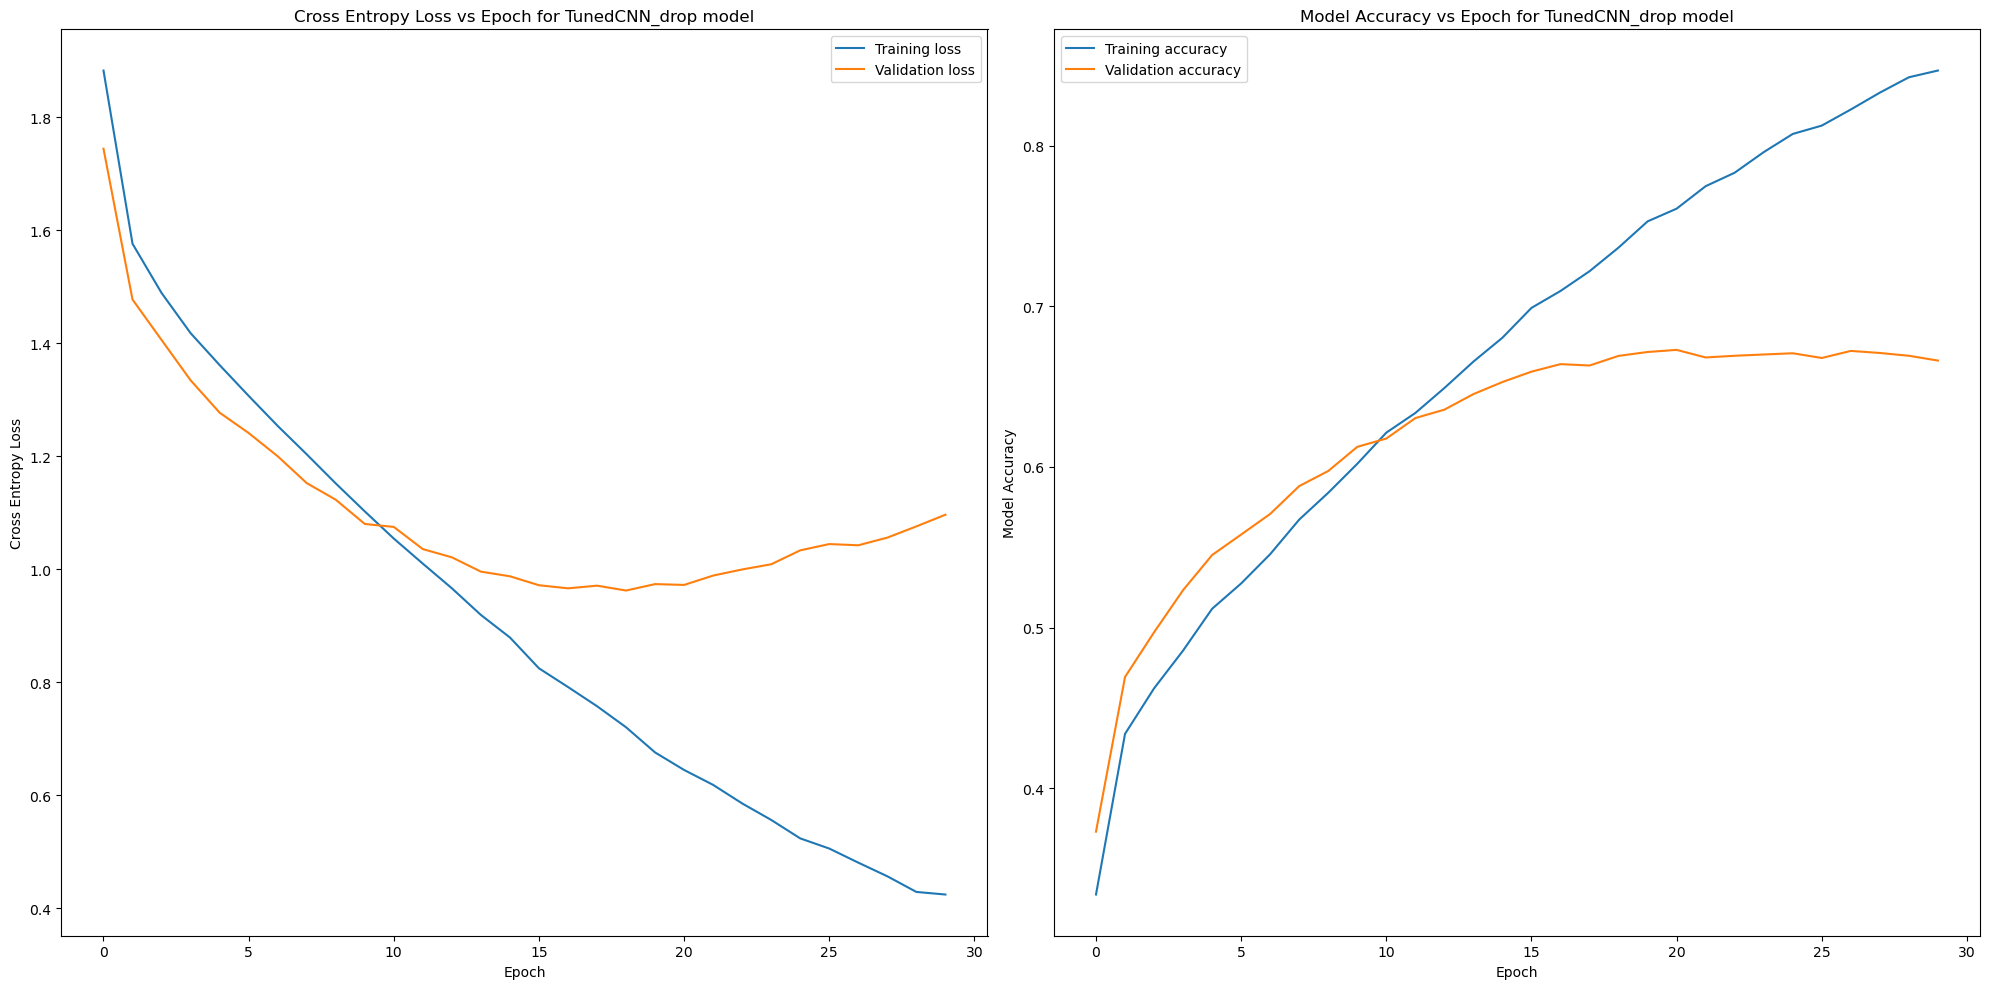

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))  # 1 row, 2 columns

# Cross Entropy Loss vs Epoch for Linear model
axs[0].plot(train_loss_drop, label='Training loss')
axs[0].plot(val_loss_drop, label='Validation loss')
axs[0].set_title('Cross Entropy Loss vs Epoch for TunedCNN_drop model')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Cross Entropy Loss')
axs[0].legend()

# Model Accuracy vs Epoch for Linear model
axs[1].plot(train_acc_drop, label='Training accuracy')
axs[1].plot(val_acc_drop, label='Validation accuracy')
axs[1].set_title('Model Accuracy vs Epoch for TunedCNN_drop model')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Model Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()


In [13]:
best_vloss_drop = min(val_loss_drop)
index_best_vloss_drop = val_loss_drop.index(best_vloss_drop)
best_acc_drop = max(val_acc_drop)
index_best_acc_drop = val_acc_drop.index(best_acc_drop)
print(f"Best validation loss with dropout: {best_vloss_drop}, Epoch: {index_best_vloss_drop}")
print(f"Best accuracy with dropout: {best_acc_drop}, Epoch: {index_best_acc_drop}")

Best validation loss with dropout: 0.9621707095819361, Epoch: 18
Best accuracy with dropout: 0.6728588235294118, Epoch: 20


# Feature Arrtibution on Animal Images

## 11. Using the https://github.com/bstadie/Stat_415_Spring_2023/blob/main/homework-4/smooth_grad.py, run SmoothGrad on one your convolutional model from step 10. Produce a graphic similar to those in Lecture 10, which shows a heatmap of the gradient on the image demonstrating what pixels SmoothGrad is selecting on. See for example https://www.semanticscholar.org/paper/SmoothGrad%3A-removing-noise-by-adding-noise-Smilkov-Thorat/f538dca4def5167a32fbc12107b69a05f0c9d832/figure/2.

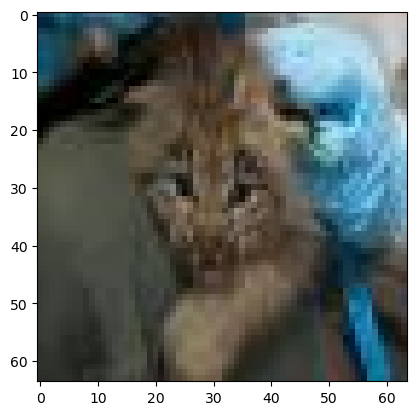

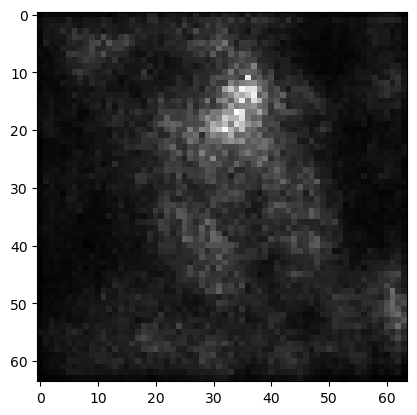

In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

class VanillaGrad:
    """ Class for computing gradients of the output w.r.t an input image for a pretrained model """

    def __init__(self, pretrained_model, cuda=True):
        self.pretrained_model = pretrained_model
        self.cuda = cuda

    def __call__(self, x, index=None):
        x.requires_grad_(True)
        output = self.pretrained_model(x)

        # If no index is provided, select the class with the highest probability
        if index is None:
            index = output.argmax(dim=1).item()

        one_hot = torch.zeros_like(output)
        one_hot[:, index] = 1
        one_hot = one_hot.to(x.device) if self.cuda else one_hot

        # Zero gradients
        self.pretrained_model.zero_grad()
        output.backward(gradient=one_hot)
        grad = x.grad.data

        return grad


class SmoothGrad(VanillaGrad):
    """ Class for computing SmoothGrad, which averages gradients of the output w.r.t input image over
        multiple noisy versions of the input """

    def __init__(self, pretrained_model, cuda=True, stdev_spread=0.15, n_samples=25, magnitude=True):
        super(SmoothGrad, self).__init__(pretrained_model, cuda)
        self.stdev_spread = stdev_spread
        self.n_samples = n_samples
        self.magnitude = magnitude

    def __call__(self, x, index=None):
        stdev = self.stdev_spread * (x.max() - x.min())
        total_gradients = torch.zeros_like(x)

        for _ in range(self.n_samples):
            noise = torch.normal(0, stdev, size=x.shape).to(x.device) if self.cuda else torch.normal(0, stdev, size=x.shape)
            x_plus_noise = x + noise

            grad = super(SmoothGrad, self).__call__(x_plus_noise, index=index)

            if self.magnitude:
                total_gradients += (grad * grad)
            else:
                total_gradients += grad

        avg_gradients = total_gradients / self.n_samples
        return avg_gradients


# Note: This is an overly simplified model and is meant for demonstration purposes only.
# It is used here as a placeholder. You should use what you've built for the previous questions.


## Use TunedCNN_drop
class TunedCNN_drop(nn.Module):
    def __init__(self):
        super(TunedCNN_drop, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout2d(0.2)  # Dropout after the second conv layer
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout2 = nn.Dropout2d(0.2)  # Dropout after the fourth conv layer

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.dropout3 = nn.Dropout(0.5)  # Dropout before the last fully connected layer
        
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.dropout1(self.pool(F.leaky_relu(self.bn2(self.conv2(x)))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.dropout2(self.pool(F.leaky_relu(self.bn4(self.conv4(x)))))
        
        x = x.reshape(x.size(0), -1)
        
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout3(x)  # apply dropout after ReLU
        x = self.fc2(x)
        
        return x


if __name__ == '__main__':
    # Initialize your model by calling the class that defines your model architecture.
    # Here, 'ExampleCNN' is a placeholder for your model choice.
    model = TunedCNN_drop()
    # The weights from your pretrained model should be saved in a .pt file.
    model_weights = './TunedCNN_drop/E18B300_TunedCNN_drop.pt'
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Uncomment the following line to load the weights into the model.
    # 'torch.load' will load the weights, and 'model.load_state_dict' will apply these weights to your model.
    # Make sure that the architecture of 'model' matches the architecture of the model that the weights came from.
    model.load_state_dict(torch.load(model_weights))

    # Set the model to evaluation mode.
    # This step is necessary because it tells your model that it will be used for inference, not training.
    # In evaluation mode, certain layers like dropout are disabled.
    model.eval()

    # Initialize SmoothGrad. It will average the gradients over 25 noisy versions of the input. Each noisy version is
    # obtained by adding Gaussian noise to the input with a standard deviation of 15% of the input's range.
    # You can change these numbers to vary noise levels and number of images for averaging.
    smooth_grad = SmoothGrad(pretrained_model=model, cuda=True, stdev_spread=0.15, n_samples=25, magnitude=True)

    # Here, you will need to replace 'YOUR_IMAGE_TENSOR' with your actual image tensor. Something like norm_train_images[0].
    my_image = train_images[817].permute(1, 2, 0)
    example_image = norm_train_images[817].to(device)

    # Compute the SmoothGrad saliency map
    # The image tensor is unsqueezed to add an extra dimension because the model expects a batch of images.
    # The dtype is set to float32, as the model expects input data in this format.
    smooth_saliency = smooth_grad(example_image.to(dtype=torch.float32).unsqueeze(0))

    # Convert the saliency map to absolute values, because we are interested in the magnitude of the gradients,
    # regardless of their direction.
    abs_saliency = np.abs(smooth_saliency.cpu().numpy())

    # Sum the absolute gradients across all color channels to get a single saliency map.
    # 'squeeze' is used to remove the extra dimension that was added earlier.
    saliency_map = np.sum(abs_saliency, axis=1).squeeze()

    # Display the final saliency map. The brighter a pixel in the saliency map, the more important it is for the model's decision.
    plt.imshow(my_image)
    plt.show()
    
    plt.imshow(saliency_map, cmap='gray')
    plt.show()

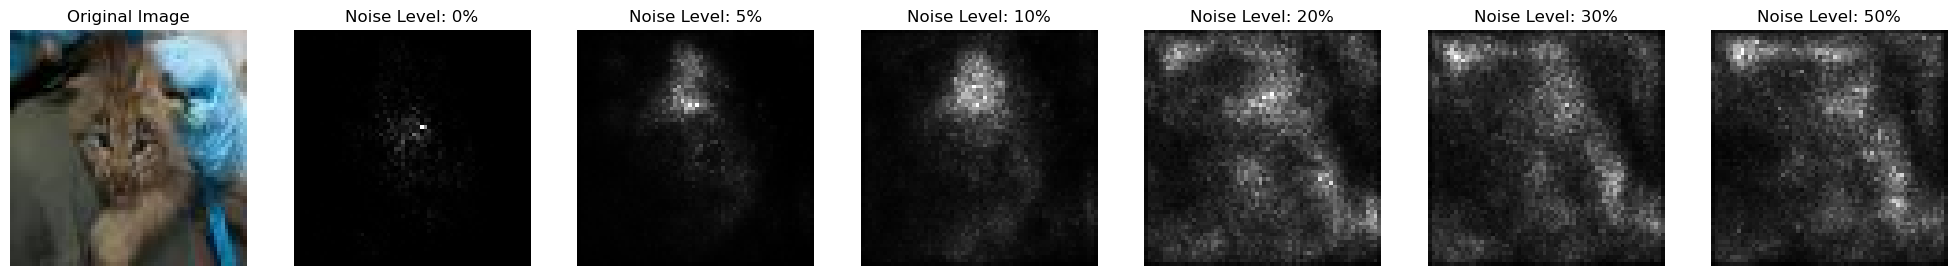

In [16]:
import matplotlib.pyplot as plt
import numpy as np

noise_levels = [0, 0.05, 0.1, 0.2, 0.3, 0.5]


# Set up the figure with 7 subplots in a row
fig, axs = plt.subplots(1, 7, figsize=(25, 10))

# Plot the original image in the first subplot
axs[0].imshow(my_image)
axs[0].set_title('Original Image')

for i, noise_level in enumerate(noise_levels, start=1):
    # Initialize SmoothGrad with the current noise level
    smooth_grad = SmoothGrad(model, cuda=True, stdev_spread=noise_level, n_samples=25, magnitude=True)

    # Compute SmoothGrad saliency map
    smooth_saliency = smooth_grad(example_image.to(dtype=torch.float32).unsqueeze(0))

    # Convert saliency map to absolute values and sum across color channels
    abs_saliency = np.abs(smooth_saliency.cpu().numpy())
    saliency_map = np.sum(abs_saliency, axis=1).squeeze()

    # Plot the saliency map for the current noise level in the next subplot
    axs[i].imshow(saliency_map, cmap='gray')
    axs[i].set_title(f'Noise Level: {int(noise_level*100)}%')

# Remove axis details for better visualization
for ax in axs:
    ax.axis('off')

plt.show()




## 12. Similarly, use LIME on images to generate an explanation of what features your convolutional net from step 10 is selecting on. See for example https://raw.githubusercontent.com/marcotcr/lime/master/doc/images/images.png. Starter code is https://github.com/bstadie/Stat_415_Spring_2023/blob/main/homework-4/LIME.py. Compare the features selected on by LIME and SmoothGrad. Are there any common features for certain animals?

  0%|          | 0/1000 [00:00<?, ?it/s]

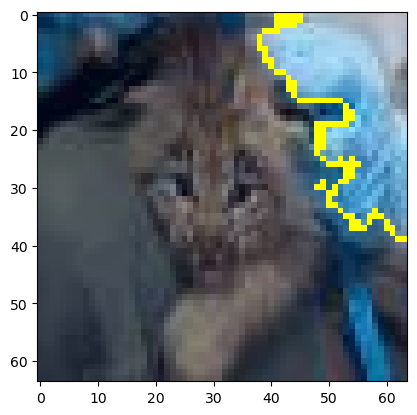

In [26]:
import numpy as np
import torch
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import dask

# Use TunedCNN_drop
## Use TunedCNN_drop
class TunedCNN_drop(nn.Module):
    def __init__(self):
        super(TunedCNN_drop, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout2d(0.2)  # Dropout after the second conv layer
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout2 = nn.Dropout2d(0.2)  # Dropout after the fourth conv layer

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.dropout3 = nn.Dropout(0.5)  # Dropout before the last fully connected layer
        
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.dropout1(self.pool(F.leaky_relu(self.bn2(self.conv2(x)))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.dropout2(self.pool(F.leaky_relu(self.bn4(self.conv4(x)))))
        
        x = x.reshape(x.size(0), -1)
        
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout3(x)  # apply dropout after ReLU
        x = self.fc2(x)
        
        return x

# Function to predict model output given images and the model
def predict_fn(images, model):
    images = torch.from_numpy(images).permute(0, 3, 1, 2).float().to(device)
    logits = model(images)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()


# Function to rescale image values to be within 0-1 range.
# This is necessary because 'mark_boundaries' function expects image pixel values between 0 and 1.
def rescale_image(image):
    image_min = image.min()
    image_max = image.max()
    image = (image - image_min) / (image_max - image_min + 1e-5)
    return image


if __name__ == '__main__':
    # Initialize the model
    model = TunedCNN_drop()

    # Load your pre-trained model weights here
    # model.load_state_dict(torch.load('path_to_your_model_weights.pt'))
    # The weights from your pretrained model should be saved in a .pt file.
    model_weights = './TunedCNN_drop/E18B300_TunedCNN_drop.pt'
    model.load_state_dict(torch.load(model_weights))
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Set the model to evaluation mode.
    model.eval()

    # Initialize LIME explainer
    explainer = lime_image.LimeImageExplainer()

    # Here, you will need to replace 'YOUR_IMAGE_TENSOR' with your actual image tensor. Something like norm_train_images[0].
    example_image = norm_train_images[817]

    # Convert image to numpy and make it suitable for LIME
    test_image = example_image.permute(1, 2, 0).numpy()

    # Generate explanations
    explanation = explainer.explain_instance(test_image,
                                             lambda x: predict_fn(x, model),
                                             top_labels=5,
                                             hide_color=0,
                                             num_samples=1000)

    # Get mask for the first prediction
    # positive_only: Only use "positive" features - ones that increase the prediction probability
    # num_features: The number of superpixels to include in the explanation
    # hide_rest: If true, the non-explanation part of the image is greyed out
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                positive_only=True,
                                                num_features=10,
                                                hide_rest=False)

    # Normalize the image for visualization
    normalized_img = rescale_image(temp)

    # Visualize the explanation
    plt.imshow(mark_boundaries(normalized_img, mask))
    plt.show()  # Show the plot

  0%|          | 0/1000 [00:00<?, ?it/s]

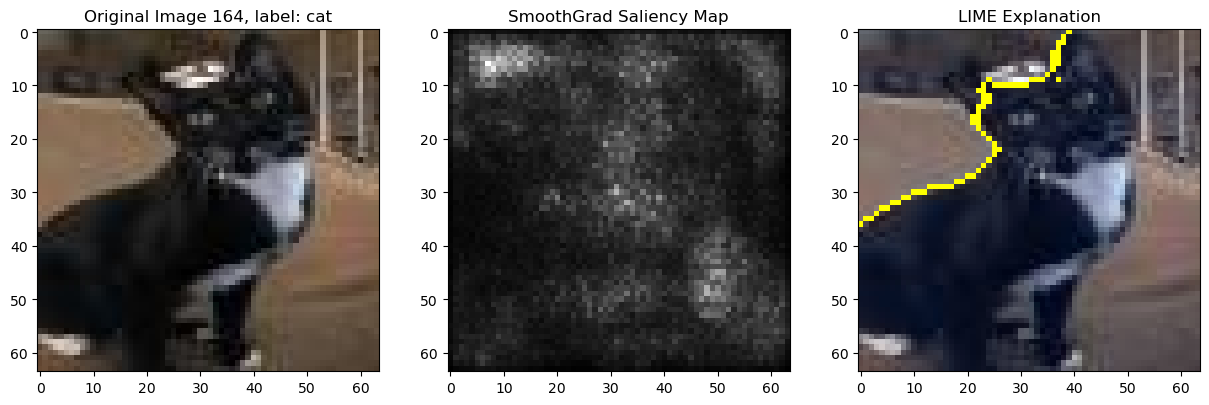

  0%|          | 0/1000 [00:00<?, ?it/s]

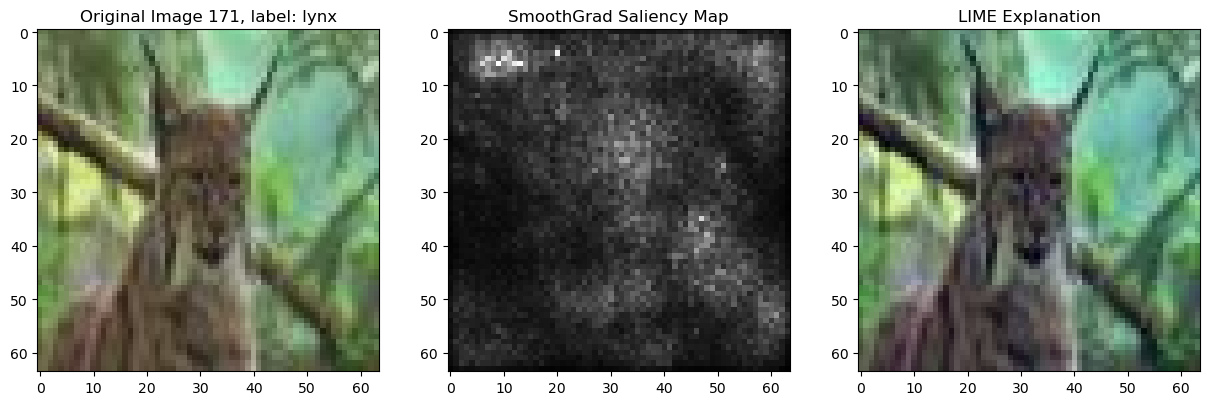

  0%|          | 0/1000 [00:00<?, ?it/s]

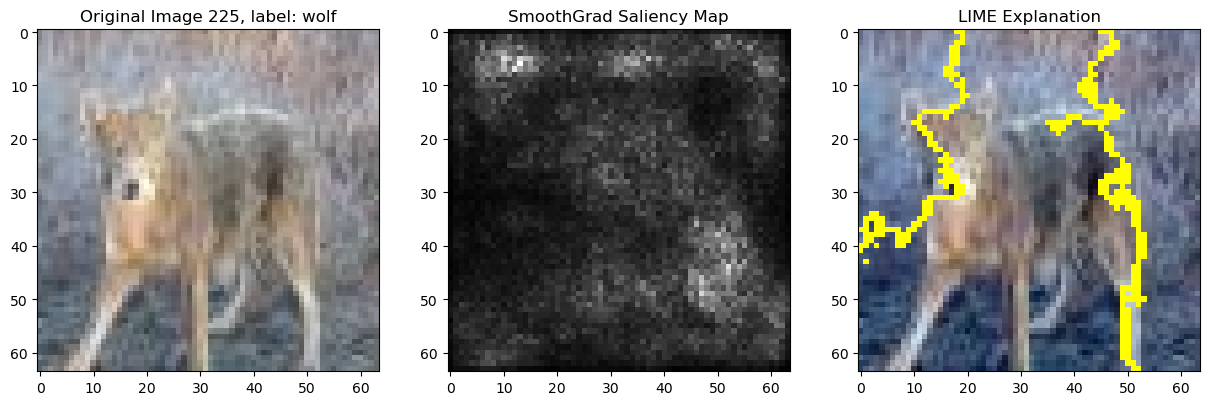

  0%|          | 0/1000 [00:00<?, ?it/s]

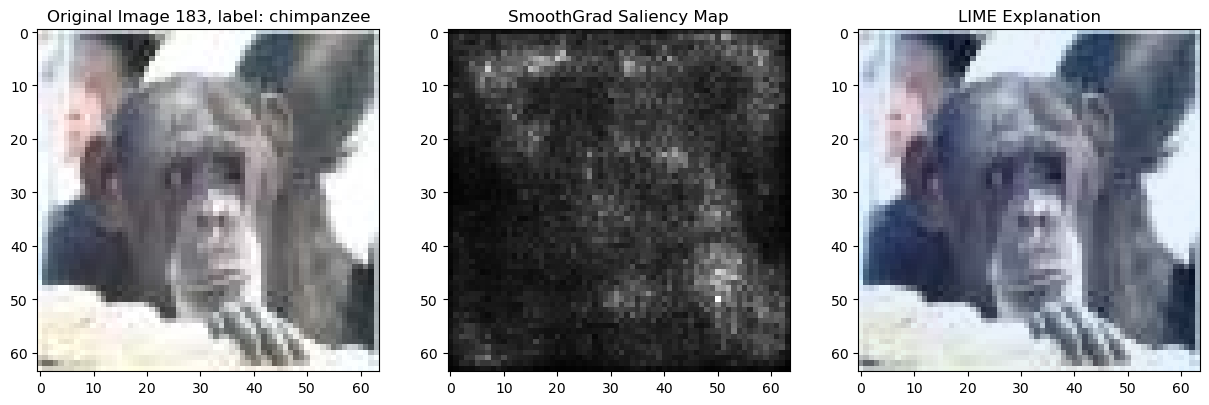

  0%|          | 0/1000 [00:00<?, ?it/s]

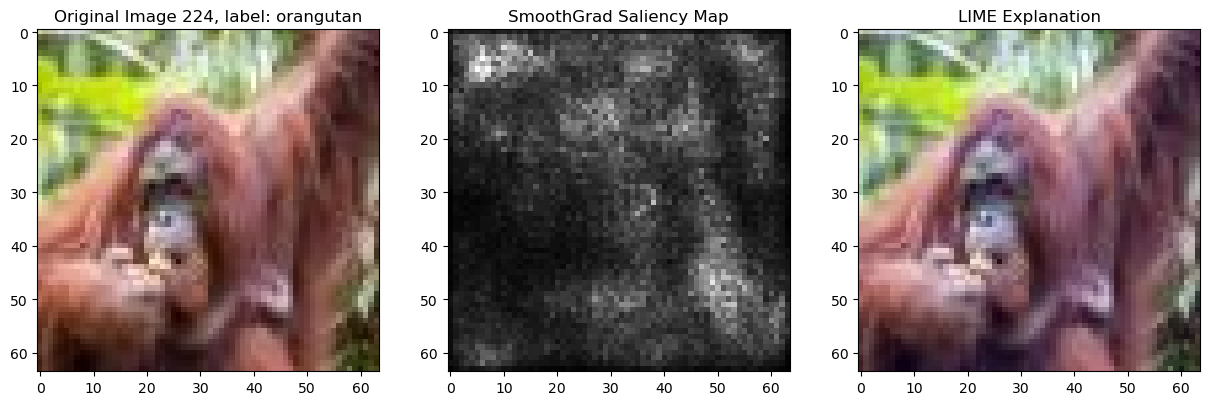

In [41]:
class_labels = ['cat', 'lynx', 'wolf', 'coyote', 'cheetah', 'jaguar', 'chimpanzee', 'orangutan', 'hamster', 'guinea pig']

# List of labels you're interested in.
label_list = [0, 1, 2, 6, 7]  # cat, lynx, wolf, chimpanzee, orangutan
image_indices = []

# Find the first occurrence of each label in your train_labels array.
for label in label_list:
    index = np.where(train_labels == label)[0][21]
    image_indices.append(index)

# Loop over the image indices.
for index in image_indices:
    # Fetch the image from your dataset.
    example_image = norm_train_images[index].to(device)
    
    # SmoothGrad
    smooth_saliency = smooth_grad(example_image.to(dtype=torch.float32).unsqueeze(0))
    abs_saliency = np.abs(smooth_saliency.cpu().numpy())
    saliency_map = np.sum(abs_saliency, axis=1).squeeze() 
    
    # LIME
    test_image = example_image.permute(1, 2, 0).cpu().numpy()
    explanation = explainer.explain_instance(test_image,
                                             lambda x: predict_fn(x, model),
                                             top_labels=5,
                                             hide_color=0,
                                             num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                positive_only=True,
                                                num_features=10,
                                                hide_rest=False)
    normalized_img = rescale_image(temp)
    
    orinial_image = train_images[index]

    # Plotting
    plt.figure(figsize=(15,5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(orinial_image.permute(1, 2, 0))
    plt.title(f'Original Image {index}, label: {class_labels[train_labels[index]]}')
    
    plt.subplot(1, 3, 2)
    plt.imshow(saliency_map, cmap='gray')
    plt.title('SmoothGrad Saliency Map')

    plt.subplot(1, 3, 3)
    plt.imshow(mark_boundaries(normalized_img, mask))
    plt.title('LIME Explanation')
    
    plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

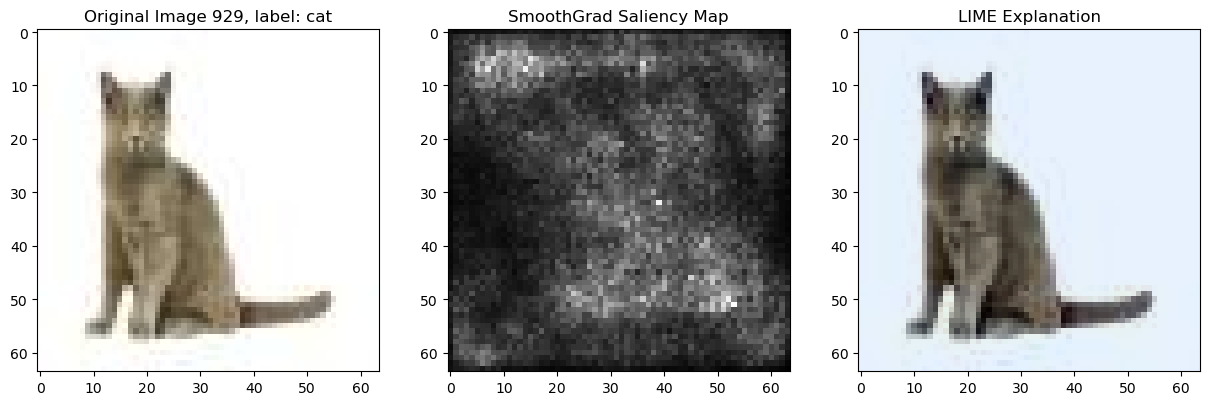

  0%|          | 0/1000 [00:00<?, ?it/s]

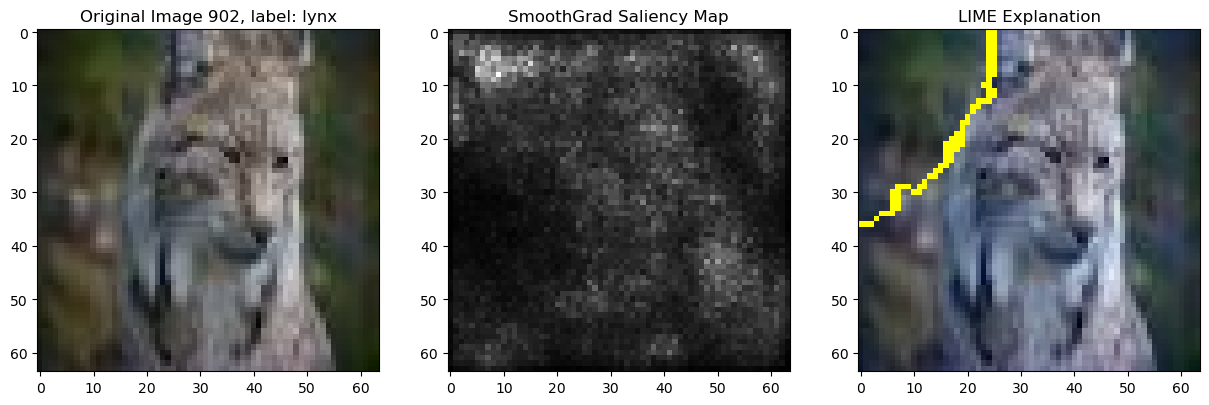

  0%|          | 0/1000 [00:00<?, ?it/s]

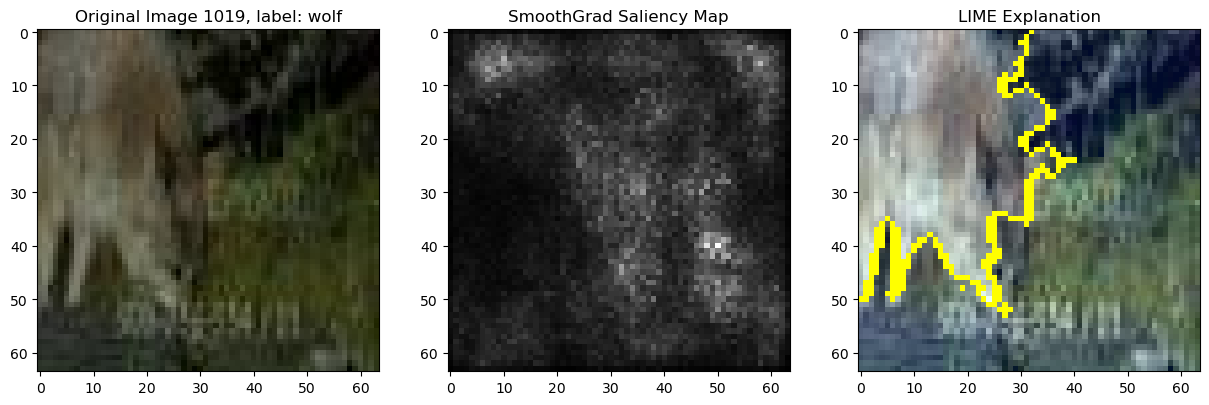

  0%|          | 0/1000 [00:00<?, ?it/s]

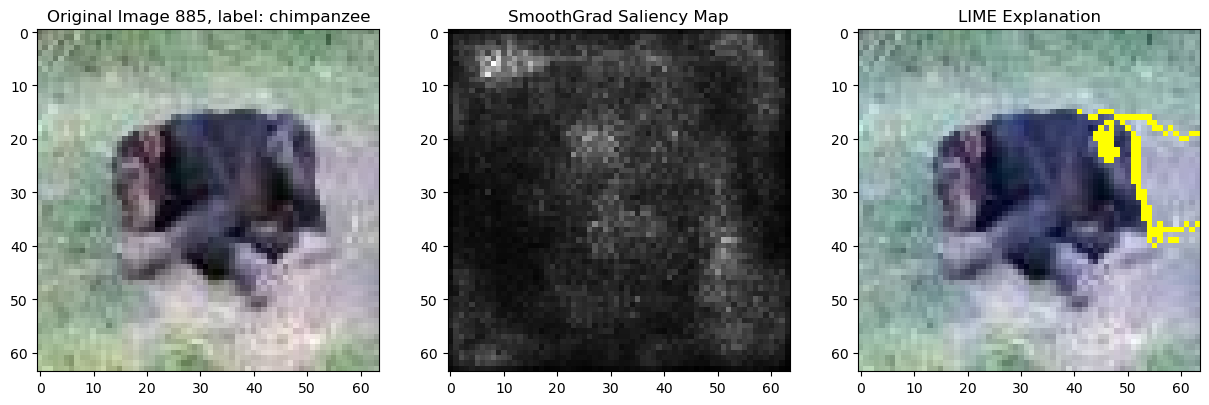

  0%|          | 0/1000 [00:00<?, ?it/s]

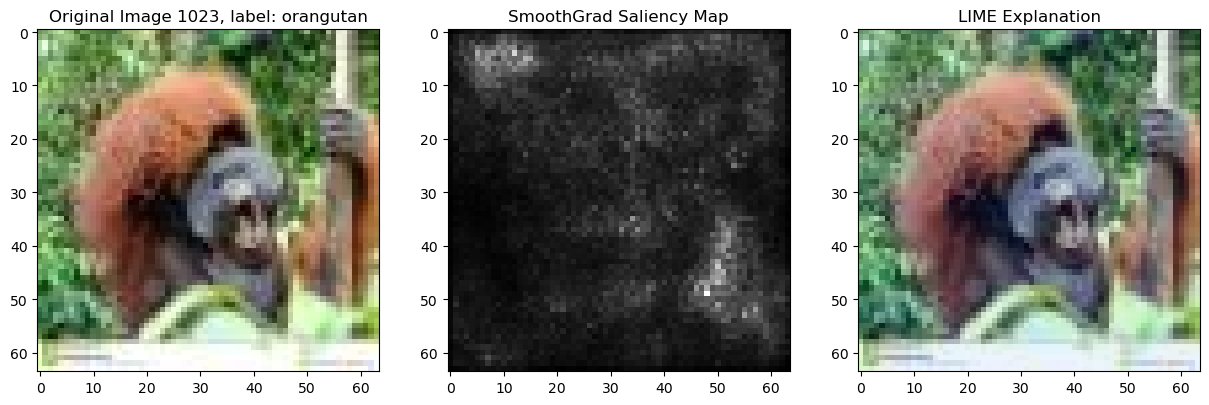

In [30]:
class_labels = ['cat', 'lynx', 'wolf', 'coyote', 'cheetah', 'jaguar', 'chimpanzee', 'orangutan', 'hamster', 'guinea pig']

# List of labels you're interested in.
label_list = [0, 1, 2, 6, 7]  # cat, lynx, wolf, chimpanzee, orangutan
image_indices = []

# Find the first occurrence of each label in your train_labels array.
for label in label_list:
    index = np.where(train_labels == label)[0][100]
    image_indices.append(index)

# Loop over the image indices.
for index in image_indices:
    # Fetch the image from your dataset.
    example_image = norm_train_images[index].to(device)
    
    # SmoothGrad
    smooth_saliency = smooth_grad(example_image.to(dtype=torch.float32).unsqueeze(0))
    abs_saliency = np.abs(smooth_saliency.cpu().numpy())
    saliency_map = np.sum(abs_saliency, axis=1).squeeze() 
    
    # LIME
    test_image = example_image.permute(1, 2, 0).cpu().numpy()
    explanation = explainer.explain_instance(test_image,
                                             lambda x: predict_fn(x, model),
                                             top_labels=5,
                                             hide_color=0,
                                             num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                positive_only=True,
                                                num_features=10,
                                                hide_rest=False)
    normalized_img = rescale_image(temp)
    
    orinial_image = train_images[index]

    # Plotting
    plt.figure(figsize=(15,5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(orinial_image.permute(1, 2, 0))
    plt.title(f'Original Image {index}, label: {class_labels[train_labels[index]]}')
    
    plt.subplot(1, 3, 2)
    plt.imshow(saliency_map, cmap='gray')
    plt.title('SmoothGrad Saliency Map')

    plt.subplot(1, 3, 3)
    plt.imshow(mark_boundaries(normalized_img, mask))
    plt.title('LIME Explanation')
    
    plt.show()
